# Project Brief Introduction
This project aims to analyze customer behavior and improve marketing strategies by leveraging a comprehensive marketing dataset. The key objectives include data preprocessing, exploratory data analysis (EDA), feature engineering, and customer segmentation. The project will utilize various statistical and machine learning techniques to uncover insights and provide actionable recommendations for enhancing marketing campaign effectiveness.

# Import Libraries and Data

In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kurtosis, skew, pointbiserialr, mannwhitneyu,randint
import statsmodels.formula.api as smf
import statsmodels as sm

import math


from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, train_test_split
from sklearn.feature_selection  import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, make_scorer,classification_report, accuracy_score,roc_auc_score
from sklearn.utils import resample
from sklearn.inspection import permutation_importance



from imblearn.over_sampling import SMOTE


import eli5
from eli5.sklearn import PermutationImportance

# import plotly.express as px
# ensures that results are consistent across runs if the randomness is involved
np.random.seed(42)

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')



In [4]:
food_df= pd.read_csv('../datasets/marketing-data/ifood_df.csv')
food_df.sample(3)

Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
1966  91712.0        0         0       47      1276         24   
1091  81698.0        0         0        1       709         45   
1468  57867.0        1         0       48       344         35   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
1966              746               94                29            48   
1091              115               30               160            45   
1468              178               15                23            17   

      NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
1966                  0                9                    7   
1091                  1                8                    2   
1468                  7                7                    2   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
1966                 11                  3             0             0   
1091                  5                  5             0             0   
1468                  9                  6             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  \
1966             1             0             0         0              3   
1091             0             1             0         0              3   
1468             0             0             0         0              3   

      Z_Revenue  Response  Age  Customer_Days  marital_Divorced  \
1966         11         1   73           2414                 0   
1091         11         1   37           2644                 0   
1468         11         0   42           2430                 0   

      marital_Married  marital_Single  marital_Together  marital_Widow  \
1966                0               1                 0              0   
1091                0               1                 0              0   
1468                0               0                 1              0   

      education_2n Cycle  education_Basic  education_Graduation  \
1966                   0                0                     0   
1091                   1                0                     0   
1468                   0                0                     1   

      education_Master  education_PhD  MntTotal  MntRegularProds  \
1966                 1              0      2169             2121   
1091                 0              0      1059             1014   
1468                 0              0       595              578   

      AcceptedCmpOverall  
1966                   1  
1091                   1  
1468                   0

In [5]:
food_df.shape

(2205, 39)

In [6]:
food_df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')

In [7]:
# check for MntTotal and AcceptedCmpOverall
# MntTotal is the sum of 'MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', and 
#                'MntSweetProducts'.i.e exclude 'MntGoldProds' and 'MntRegularProds'
assert (food_df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                'MntSweetProducts']].sum(axis=1,skipna=True) == food_df['MntTotal']).all(),\
 "The row sums do not match the total in 'MntTotal'."

# AcceptedCmpOverall is the sum of 'AccptedCmp1', 'AccptedCmp2', 'AccptedCmp3','AccptedCmp4', and 
#                'AccptedCmp5', i.e. exclude 'Response'
assert (food_df[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4',
                  'AcceptedCmp5']].sum(axis=1,skipna=True) == \
        food_df['AcceptedCmpOverall']).all(),"The row sums do not match the total in 'AcceptedCmpOverall'."


**Data Dictionary**  

|Idx|Column Name|Description|Comment|
|---|---|---|---|
|1|Income|Customer's yearly household income|Potential indicator of purchasing power|
|2|Kidhome|Number of children in the household|Relevant for family-oriented marketing|
|3|Teenhome|Number of teenagers in the household|Impacts household purchasing decisions|
|4|Recency|Days since last purchase|Measures customer engagement|
|5|MntWines|Amount spent on wines in last 2 years|Product category spending|
|6|MntFruits|Amount spent on fruits in last 2 years|Product category spending|
|7|MntMeatProducts|Amount spent on meat products in last 2 years|Product category spending|
|8|MntFishProducts|Amount spent on fish products in last 2 years|Product category spending|
|9|MntSweetProducts|Amount spent on sweet products in last 2 years|Product category spending|
|10|MntGoldProds|Amount spent on gold products in last 2 years|Luxury or premium product spending|
|11|NumDealsPurchases|Number of purchases made with a discount|Indicates price sensitivity|
|12|NumWebPurchases|Number of purchases made through the website|Online shopping behavior|
|13|NumCatalogPurchases|Number of purchases made through catalog|Traditional shopping channel|
|14|NumStorePurchases|Number of purchases made in-store|Physical retail shopping behavior|
|15|NumWebVisitsMonth|Number of website visits per month|Online engagement|
|16|AcceptedCmp1|1 if customer accepted the offer in the 1st campaign, 0 otherwise|Marketing campaign effectiveness|
|17|AcceptedCmp2|1 if customer accepted the offer in the 2nd campaign, 0 otherwise|Marketing campaign effectiveness|
|18|AcceptedCmp3|1 if customer accepted the offer in the 3rd campaign, 0 otherwise|Marketing campaign effectiveness|
|19|AcceptedCmp4|1 if customer accepted the offer in the 4th campaign, 0 otherwise|Marketing campaign effectiveness|
|20|AcceptedCmp5|1 if customer accepted the offer in the 5th campaign, 0 otherwise|Marketing campaign effectiveness|
|21|Complain|1 if customer complained in the last 2 years, 0 otherwise|Customer satisfaction indicator|
|22|Z_CostContact|Need further research|Requires additional investigation|
|23|Z_Revenue|Need further research|Requires additional investigation|
|24|Response|1 if customer accepted the offer in the last campaign, 0 otherwise|Marketing campaign effectiveness|
|25|Age|Customer's age|Demographic information|
|26|Customer_Days|Number of days since becoming a customer|Customer loyalty measure|
|27|marital_Divorced|Marital status - Divorced|Demographic segmentation|
|28|marital_Married|Marital status - Married|Demographic segmentation|
|29|marital_Single|Marital status - Single|Demographic segmentation|
|30|marital_Together|Marital status - Together|Demographic segmentation|
|31|marital_Widow|Marital status - Widow|Demographic segmentation|
|32|education_2n Cycle|Education level - 2nd Cycle|Educational background|
|33|education_Basic|Education level - Basic|Educational background|
|34|education_Graduation|Education level - Graduation|Educational background|
|35|education_Master|Education level - Master|Educational background|
|36|education_PhD|Education level - PhD|Educational background|
|37|MntTotal|Total amount spent|Overall customer spending exclude `MntRegularProds` and `MntGoldeProds`|
|38|MntRegularProds|Amount spent on regular products|Regular product purchasing|
|39|AcceptedCmpOverall|Overall campaign acceptance exclude `Respons`|Cumulative marketing effectiveness|

# Data preprocessing
* Check for missing values
* Identify and addess any inconsistencies or errors in data
* Access the data's distribution and identify outliers


## Checking Missing Data 
There is no missing data


In [8]:
missing_values = food_df.isnull().sum()
missing_values = missing_values[missing_values>0]
print(f"\nMissing Values:{missing_values}")


Missing Values:Series([], dtype: int64)


## Identify Inconsisitencies or Errors in Data

In [9]:
# check for duplicates. I'll keep all duplicates for there is no unique identifier
duplicates = food_df.duplicated()
print(f"Duplicates: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("Duplicates rows:\n", food_df[duplicates])

Duplicates: 184
Duplicates rows:
        Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
77    38620.0        0         0       56       112         17   
167   78497.0        0         0       44       207         26   
267   51369.0        0         1       84       297          7   
268   37760.0        0         0       20        84          5   
346   37717.0        1         0       31         9          0   
...       ...      ...       ...      ...       ...        ...   
2185  22775.0        1         0       40         5          1   
2188  75777.0        0         0       12       712         26   
2192  58554.0        1         1       55       368         24   
2199  34421.0        1         0       81         3          3   
2201  64014.0        2         1       56       406          0   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
77                 44               34                22            89   
167               447    

In [10]:
# check for data type mismatch
print(f"Data types:\n{food_df.dtypes}")

Data types:
Income                  float64
Kidhome                   int64
Teenhome                  int64
Recency                   int64
MntWines                  int64
MntFruits                 int64
MntMeatProducts           int64
MntFishProducts           int64
MntSweetProducts          int64
MntGoldProds              int64
NumDealsPurchases         int64
NumWebPurchases           int64
NumCatalogPurchases       int64
NumStorePurchases         int64
NumWebVisitsMonth         int64
AcceptedCmp3              int64
AcceptedCmp4              int64
AcceptedCmp5              int64
AcceptedCmp1              int64
AcceptedCmp2              int64
Complain                  int64
Z_CostContact             int64
Z_Revenue                 int64
Response                  int64
Age                       int64
Customer_Days             int64
marital_Divorced          int64
marital_Married           int64
marital_Single            int64
marital_Together          int64
marital_Widow             in

In [11]:
# Cross-field validation
# check for impossible values, like person's age being less than 0 or greater than 120
impossible_age = food_df[(food_df['Age'] < 0) | (food_df['Age'] > 120)]
print(f"Impossible age: {impossible_age}")

# check for impossible values, like person's income being less than 0
impossible_income = food_df[food_df['Income'] < 0]
print(f"Impossible income: {impossible_income}")

# check for impossible values, like person stays in multiple marital statuses
impossible_marital = food_df[food_df[['marital_Divorced', 'marital_Married','marital_Single', 'marital_Together','marital_Widow']].sum(axis=1) > 1]
print(f"Impossible marital status: {impossible_marital}")

Impossible age: Empty DataFrame
Columns: [Income, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response, Age, Customer_Days, marital_Divorced, marital_Married, marital_Single, marital_Together, marital_Widow, education_2n Cycle, education_Basic, education_Graduation, education_Master, education_PhD, MntTotal, MntRegularProds, AcceptedCmpOverall]
Index: []
Impossible income: Empty DataFrame
Columns: [Income, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Re

## Assess Data Distribution and Identify outliers
Using hist and box plot to assess each variable's distribution and identify outliers


In [12]:
# check the data overall info
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

In [13]:
#summary statistics
food_df.describe()

Income      Kidhome     Teenhome      Recency     MntWines  \
count    2205.000000  2205.000000  2205.000000  2205.000000  2205.000000   
mean    51622.094785     0.442177     0.506576    49.009070   306.164626   
std     20713.063826     0.537132     0.544380    28.932111   337.493839   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35196.000000     0.000000     0.000000    24.000000    24.000000   
50%     51287.000000     0.000000     0.000000    49.000000   178.000000   
75%     68281.000000     1.000000     1.000000    74.000000   507.000000   
max    113734.000000     2.000000     2.000000    99.000000  1493.000000   

         MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
count  2205.000000      2205.000000      2205.000000       2205.000000   
mean     26.403175       165.312018        37.756463         27.128345   
std      39.784484       217.784507        54.824635         41.130468   
min       0.000000         0.000000         0.000000          0.000000   
25%       2.000000        16.000000         3.000000          1.000000   
50%       8.000000        68.000000        12.000000          8.000000   
75%      33.000000       232.000000        50.000000         34.000000   
max     199.000000      1725.000000       259.000000        262.000000   

       MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count   2205.000000        2205.000000      2205.000000          2205.000000   
mean      44.057143           2.318367         4.100680             2.645351   
std       51.736211           1.886107         2.737424             2.798647   
min        0.000000           0.000000         0.000000             0.000000   
25%        9.000000           1.000000         2.000000             0.000000   
50%       25.000000           2.000000         4.000000             2.000000   
75%       56.000000           3.000000         6.000000             4.000000   
max      321.000000          15.000000        27.000000            28.000000   

       NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count        2205.000000        2205.000000   2205.000000   2205.000000   
mean            5.823583           5.336961      0.073923      0.074376   
std             3.241796           2.413535      0.261705      0.262442   
min             0.000000           0.000000      0.000000      0.000000   
25%             3.000000           3.000000      0.000000      0.000000   
50%             5.000000           6.000000      0.000000      0.000000   
75%             8.000000           7.000000      0.000000      0.000000   
max            13.000000          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  \
count   2205.000000   2205.000000   2205.000000  2205.000000         2205.0   
mean       0.073016      0.064399      0.013605     0.009070            3.0   
std        0.260222      0.245518      0.115872     0.094827            0.0   
min        0.000000      0.000000      0.000000     0.000000            3.0   
25%        0.000000      0.000000      0.000000     0.000000            3.0   
50%        0.000000      0.000000      0.000000     0.000000            3.0   
75%        0.000000      0.000000      0.000000     0.000000            3.0   
max        1.000000      1.000000      1.000000     1.000000            3.0   

       Z_Revenue    Response          Age  Customer_Days  marital_Divorced  \
count     2205.0  2205.00000  2205.000000    2205.000000       2205.000000   
mean        11.0     0.15102    51.095692    2512.718367          0.104308   
std          0.0     0.35815    11.705801     202.563647          0.305730   
min         11.0     0.00000    24.000000    2159.000000          0.000000   
25%         11.0     0.00000    43.000000    2339.000000          0.000000   
50%         11.0     0.00000    50.000000    2515.000000          0.000000   
75%    

### Access distribution through Hist plots

**Distribution Patterns for Each Feature**

1. **Income**: The distribution of income appears to be right-skewed, indicating that most customers have lower to moderate incomes, with fewer customers having very high incomes.

2. **Kidhome and Teenhome**: The distributions show that most households have no children or teenagers, with a medium number having one and few having two children or teenagers.

3. **Recency**: The distribution of recency is relatively uniform, suggesting that the days since the last purchase are spread out evenly across the dataset.

4. **MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, MntTotal, and MntRegularProds**: These distributions are right-skewed, indicating that most customers spend a small amount on these categories, with fewer customers spending large amounts. But it seems more customers tend to purchase more gold

5. **NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, and NumWebVisitsMonth**: The distributions indicate that most customers make a small number of purchases but visits websits multiple times, with fewer customers making a large number of purchases or visits. Stores or deals seldom have 0 amount sales comparing to web or catelog 

6. **AcceptedCmp1, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmpOverall, Complain, and Response**: These distributions are imbalanced binary, indicating whether customers accepted the campaigns, complained, or responded to the last campaign.

7. **Age**: The distribution of age appears to be normally distributed, with most customers falling within a certain age range.

8. **Customer_Days**: The distribution shows the number of days since becoming a customer, with most customers having been customers for a moderate amount of time.

9. **education_2n_Cycle, education_Basic, education_Master, and Education_PhD**: These distributions are imbalanced binary while **education_Graduation** is a balanced binary distribution

11. **Z_CostContact** and **Z_Revenue**:  These variables only have unique values which are not useful for analyzing

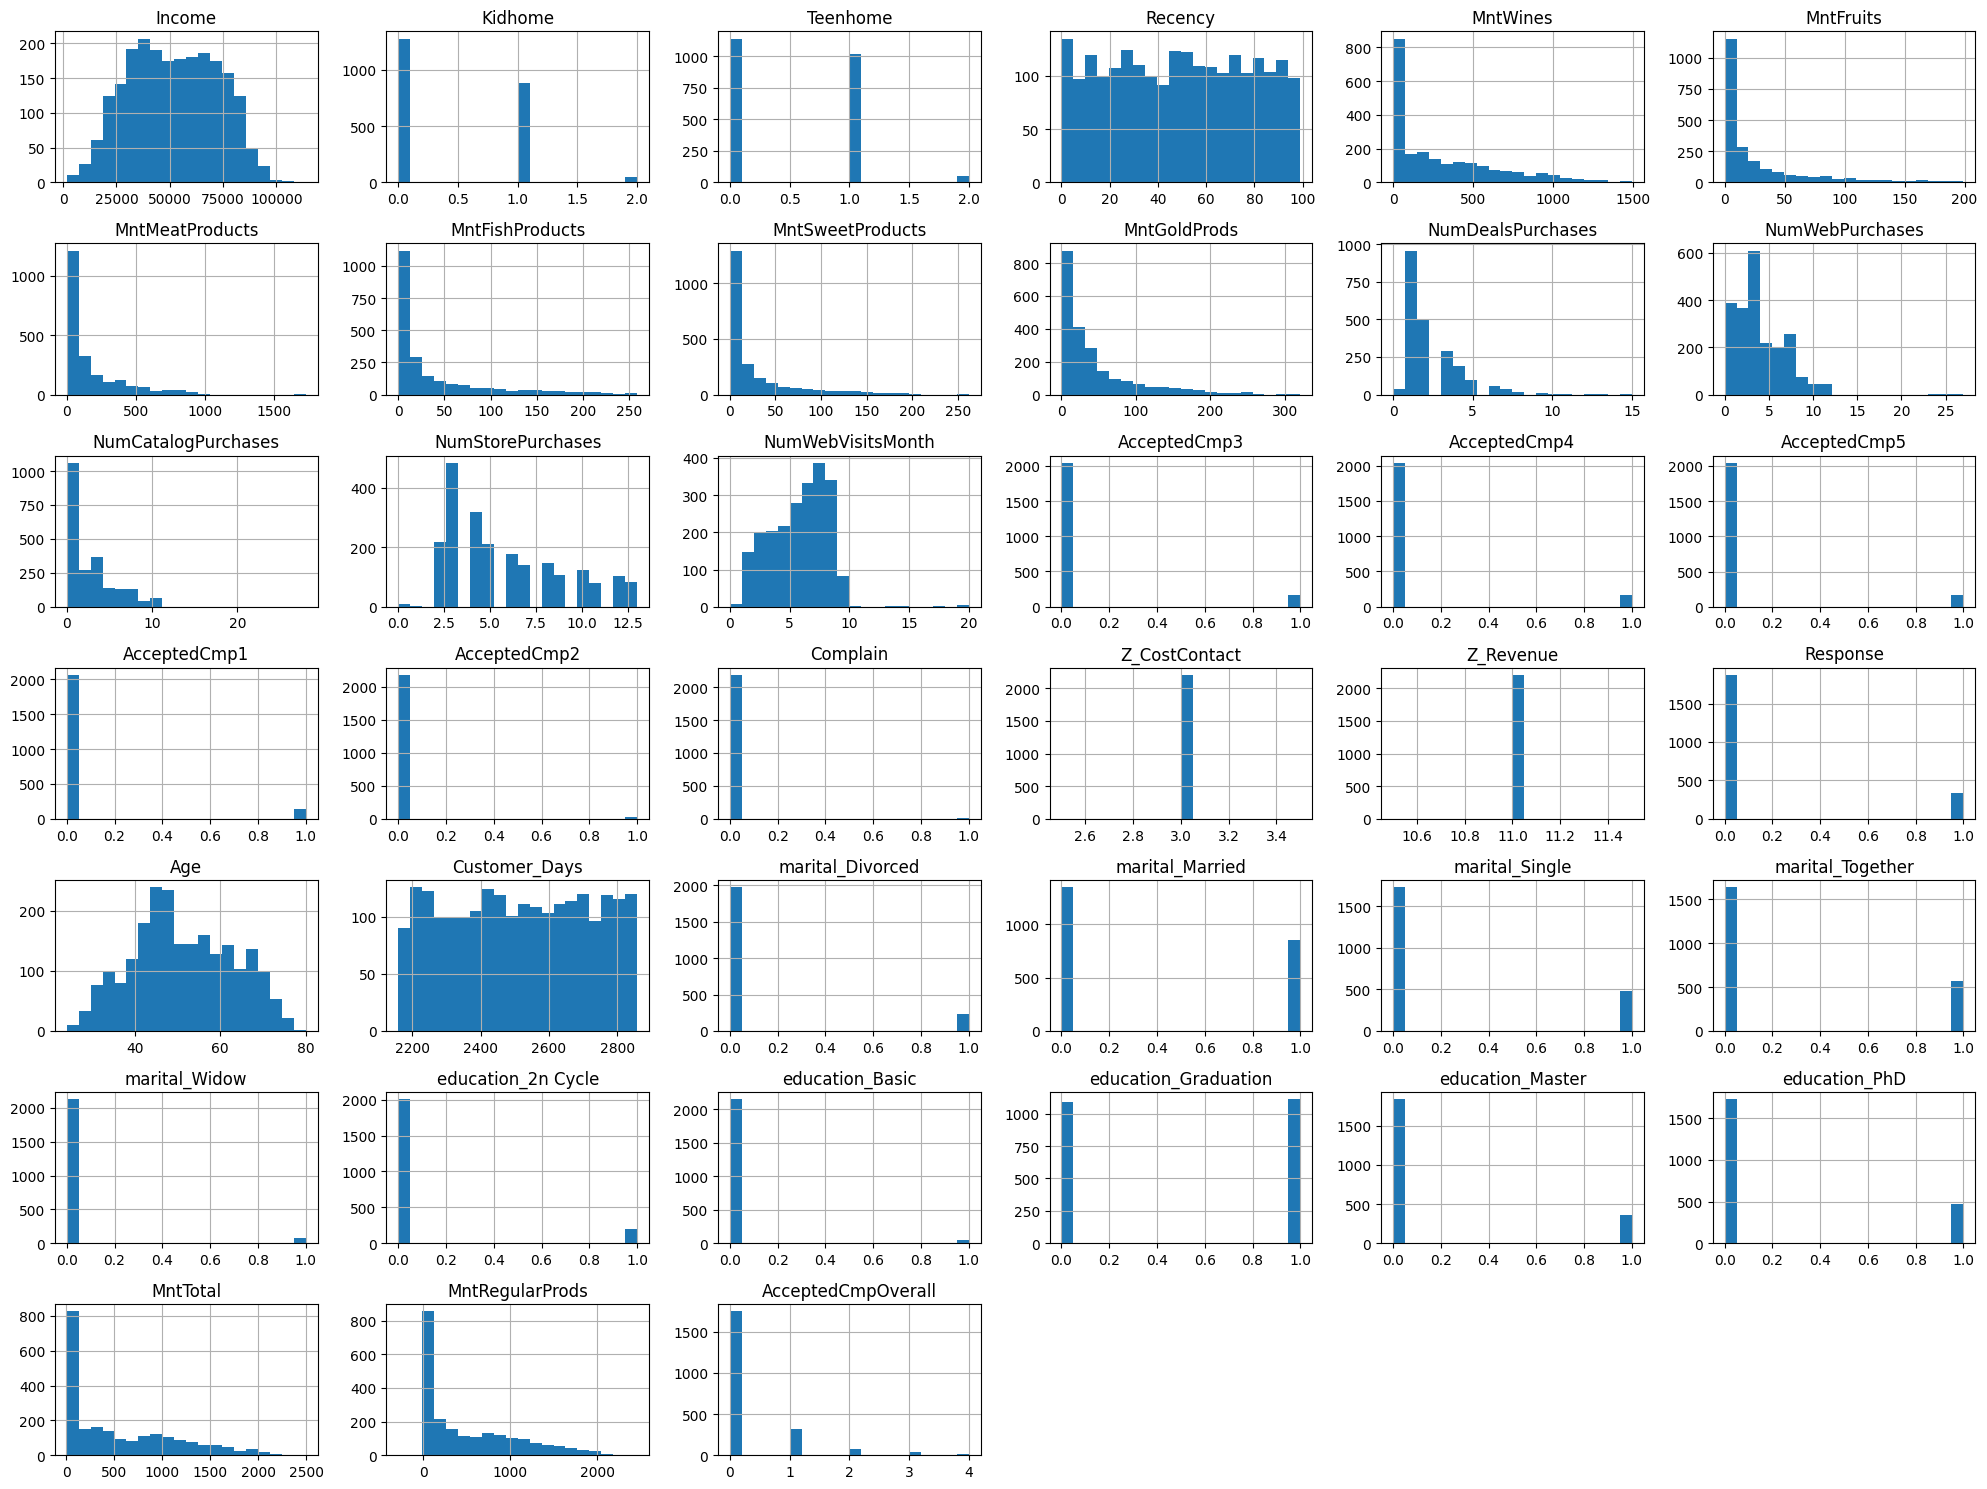

In [14]:
# check distribution of each column  through histograms 
food_df.hist(bins=20,figsize=(20,15))
plt.tight_layout();


```markdown
- The QQ plot for `Income` and `Age` against a normal distribution shows that the data points do not lie on the straight line, indicating that they are not normally distributed.

- For `Recency` and `Customer_Days` against a uniform distribution shows thtat the data points lie on the straight line, indicating that they are uniformly distributed.
```

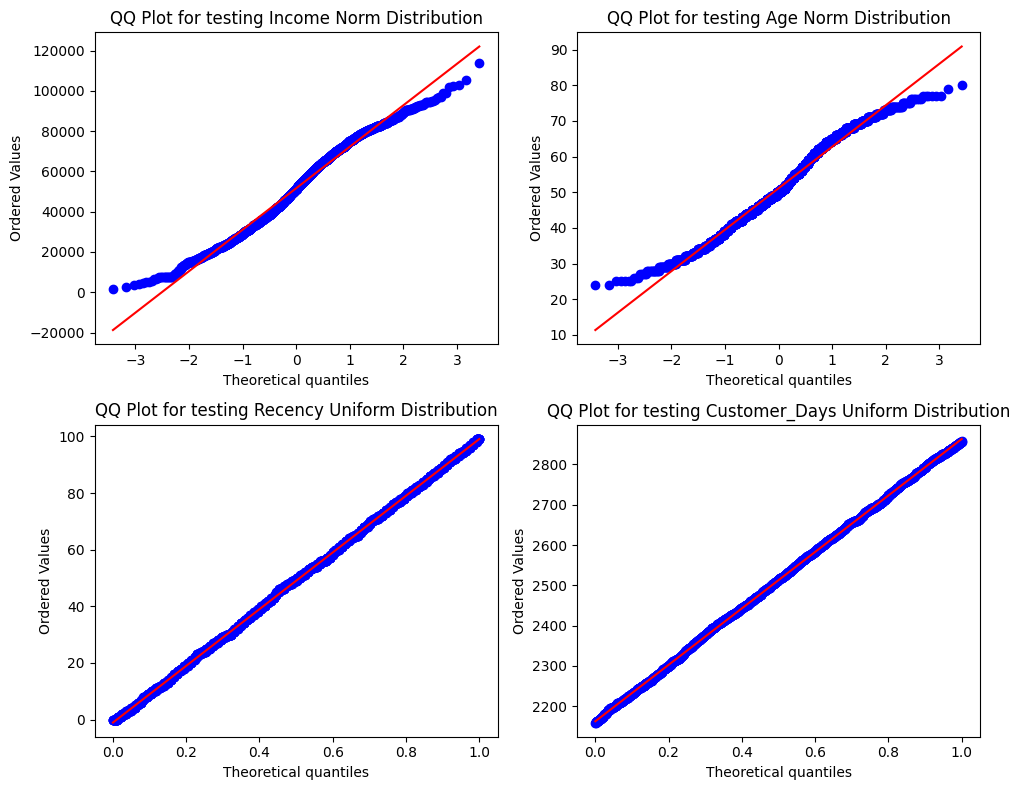

In [15]:
# Using QQplot to check whether recency and customer days are uniform distribution
# income are normal distribution 

col_dist_map ={
    'Income':'norm',
    'Age': 'norm',
    'Recency': 'uniform',
    'Customer_Days':'uniform'
}
col_num =2
row_num = math.ceil(len(col_dist_map)/col_num)
# plt.figure(figsize=(5,4))
fig, ax = plt.subplots(row_num,col_num, figsize=(5*col_num,4*row_num))

# Flatten the axes array to index it linearly
ax = ax.flatten()
for i, (col, dist) in enumerate(col_dist_map.items()):
    stats.probplot(food_df[col],dist= dist, plot=ax[i])
    ax[i].set_title(f'QQ Plot for testing {col} {dist.capitalize()} Distribution')
    

# Hide the left blank plots
for j in range(len(col_dist_map),len(ax)):
    ax[j].axis('off')
    
plt.tight_layout()
plt.show()

Linear correlation between Age and Income is 0.21
NonLinear correlation between Age and Income is 0.16


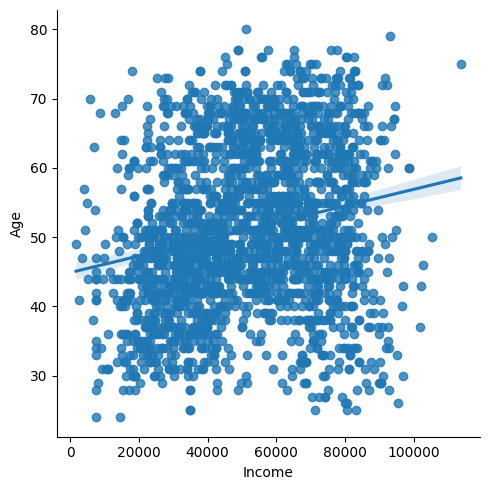

In [16]:

# There is a weak linear relationship between Income and Age
sns.lmplot(data= food_df, y= 'Age', x='Income')
print(f"Linear correlation between Age and Income is {food_df['Age'].corr(food_df['Income']).round(2)}")
print(f"NonLinear correlation between Age and Income is {food_df['Age'].corr(food_df['Income'], method='kendall').round(2)}")

### Access distribution through Box plots

In [17]:
# Identify the columns with more than 5 unique values for boxplot analysis and those with less than 5 unique values for barplot analysis
box_cols =[col for col in food_df.select_dtypes(include=np.number).columns 
           if food_df[col].nunique()>5]
le5_cols = [col for col in food_df.select_dtypes(include=np.number).columns if col not in box_cols]
le5_cols = [col for col in food_df.columns if col not in box_cols]

**MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds**: These distributions are right-skewed, indicating that most customers spend a small amount on these categories, with fewer customers spending large amounts. But for  **MntTotal, and MntRegularProds**, their outliers are comparably less than the specific products

**NumDealsPurchases, NumWebPurchases, and NumCatalogPurchases**: The distributions indicate that more customers make a small number of purchases, but with fewer customers making a large number of purchases. **NumStorePurchases** doesn't have any outliers here

**NumWebVisitMonth** is left skewed which indicate most people visit a lot and this is a possitive indicator of presenting the company brand and products.

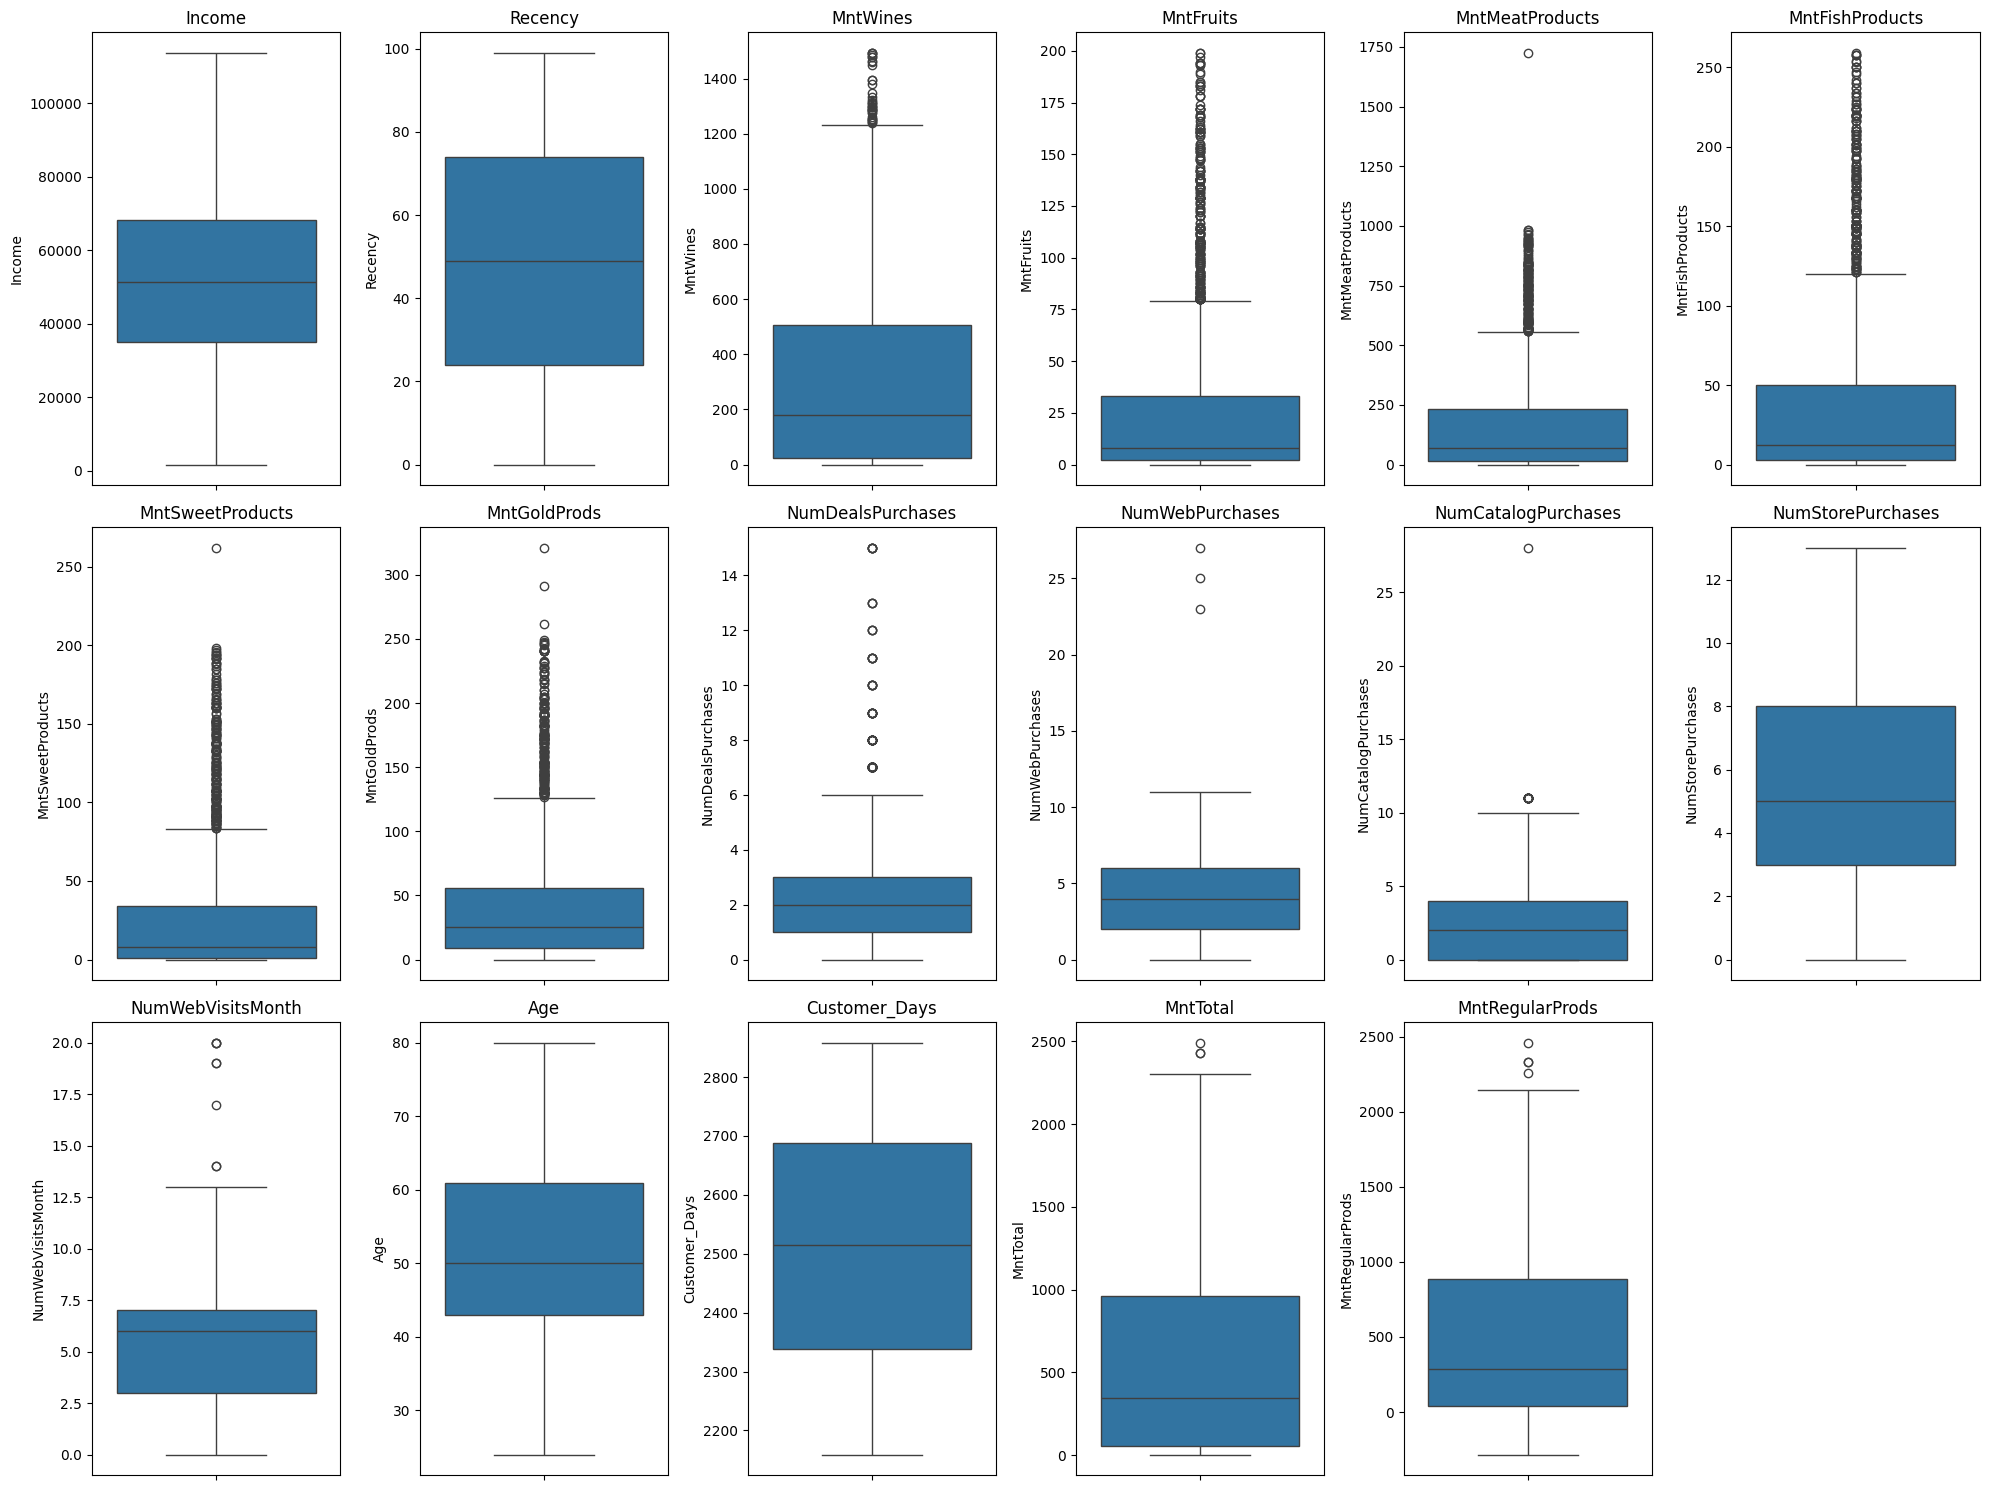

In [18]:
column = 6
row = math.ceil(len(box_cols)/column) 


# box plot for box_cols
plt.figure(figsize=(20,15))
for i, col in enumerate(box_cols,1):
    plt.subplot(row,column, i)
    sns.boxplot(y=food_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

* Most families have zero or single kid or teenager and few families has 2 kids in this dataset
* For the campaign performance, Campaign2 has the leaset acctpted rate, the **Response** has the highest accpted rate and the other campaigns have almost same accpted rate
* Few **Complain** exists in the dataset


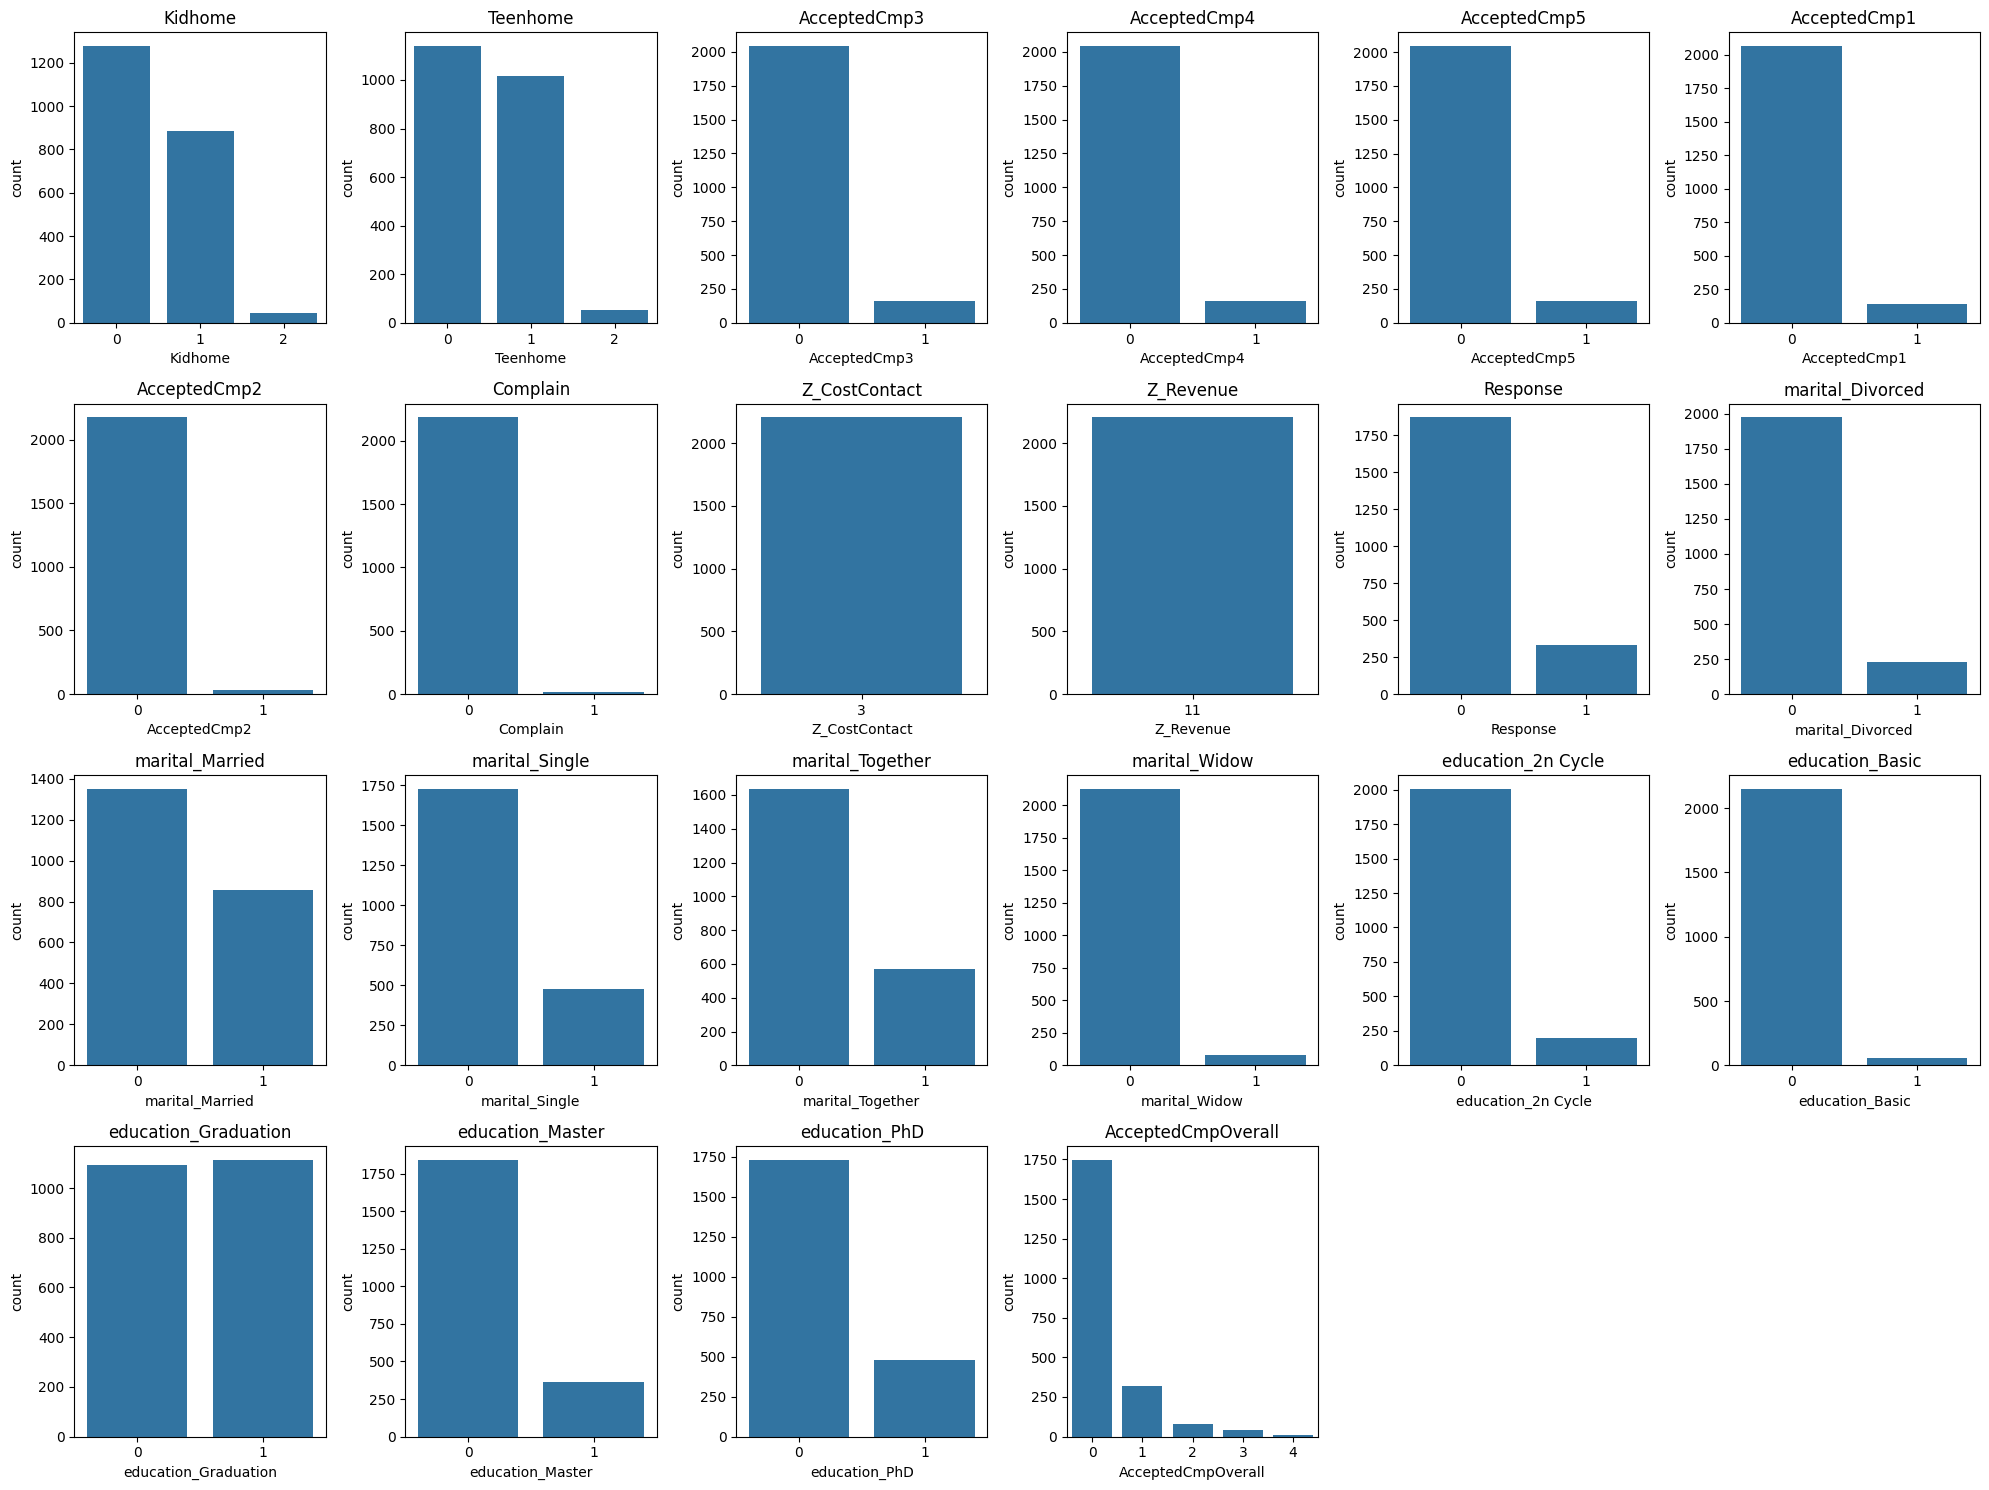

In [19]:
#bar plot for the le5_cols
# Z_CostContact and Z_revenue have only 1 value and can be removed from dataset
row = math.ceil(len(le5_cols)/column) 
plt.figure(figsize=(20,15))
for i, col in enumerate(le5_cols,1):
    plt.subplot(row,column, i)
    sns.countplot(x=food_df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

# Feature Engineering
Explore the correlation and create new features for further expoloration

## Correlation Analysis -Original

**Key Correlation Groups and Observations**  
1. Purchasing Behavior and Monetary Variables
   * **Strong Positive Correlations** (Upper Left Quadrant): A cluster of features related to purchasing products and channels: `MntgoldProds`, `MntSweeProduct`, `MntFruits`, `MntFishProducts`, `NumWebPurchases`, `NumStorePurchases`, `MntWines`, `NumCatalogPurchases`, `MntMeatProducts`, and `MntRegularProds` form a strongly inter-correlated group. This means that customers who spend more on one of these categories tend to spend more on the others , paticularly `MntRegularProds` with `MntMeatProducts` and `MntWines`.

   * Income is also highly positively correlated with this group. Higher-income individuals generally spend more across these categories. especially on wine, meat and regular products through store or catelogue purchase

Interpretation: This cluster suggests that customer spending is typically consistent. If a customer spends more in one product category, they are likely to spend more in others as well. The level of spending is primarily driven by income level.

2. Campaign Acceptance
   * **Moderate to weak Correlations with Purchase Behaviour**: The campaign acceptance variables  `AcceptedCmp2`, `AcceptedCmp3` show no correlation with purchase behavior, while `AcceptedCmp1` `AcceptedCmp4`, `AcceptedCmp5`, and `Response` show a small positive correlation with  purchasing behaviour, particularly in categories like wine, meat and regular products through store or catelogue purchases.
   * Interestingly, `NumWebVisitsMonth` shows a small  negative correlation with both purchase behaviors and Income

Interpretation: The acceptance of certain promotional campaigns does not appear to be strongly related to overall purchasing or spending behaviors.

3. Socio-Demographic Factors
  * **Moderate Correlations**: The demographic features such as `education`,`marital` status,`Age`, `TeenHome`, and `KidHome` demonstrate weak or moderate correlations with one and another, but the patterns are less clear compared to the spending behaviour cluster.

Interpretation: The demographic factors show some relationships but aren't as strongly interconnected as the spending habits. For example, marital status may correlate with age or the number of kids, but those patterns are note as pronounced as those in purchasing behavior

4. Recency, Customer_Days and Complaints
  * Low correlation with other variables `Recency`, `Customer_Days` and `Complain` show weak or almost no correlation with other features. This suggests that these features are distinct and provide unique information, warranting furtuer investigation.

Interpretation The recency of the last purchase doesn't appear be related to spennding behaviour or demographic factors though it shows weak correlation with campaign response.

5. Specific Observations
  * Positive Correlation within groups: The variables within the spending cluster show high positive correlations between each other.
  * Negative Correlations are Rare: Some variables like `Kidhome` and `NumWebVisitsMonth` show some negative correlation with the spending variables.
  * Campaigns: Most campaign features (AcceptedCmp1,4,5 and Response) are weak supoort purchase behavior, while campaign 2 and 3 show no such correlation.

6. Implications
  * Segmentation: The strong inter-correlation of purchase categories and income is useful for customer segmentation. customers could be categorized based on their overall spending level, which generally corresponds with their income.
  * Targeted Campaigns: The weak link between campaign acceptance and demographics or spending habits suggests that current campaign messaging might need improvement or that other unmeasured factors are influencing people's decisions to participate.
  * Feature Engineering: The strong correlations within the purchasing cluster could lead to the creation of aggregate features like `NumRegularPurchaseTotal`,`weighteAffordability`,`Custval`, `CustPurcFreq`. This could reduce multicollinearity and improve model performance.
  * Further Investigation: The lack of correlation between Recency and other features may indicate that recency is an important feature worth investigating on its own, providing unique insights into customer behavior.

In summary: This heatmap provides a comprehensive view of the relationships between different variables, it highlights that purchasing behavior and income are the most interconnected features. It also reveals that campaign responses do not provide strongly correlate with purchasing behavior, suggesting opportunities to improve campaign targeting and effectiveness. Additionally, the lack of strong correlations with demographic data suggests that these variables may be less relevant for marketing analysis, and new features may need to be created to enhance model efficiency.

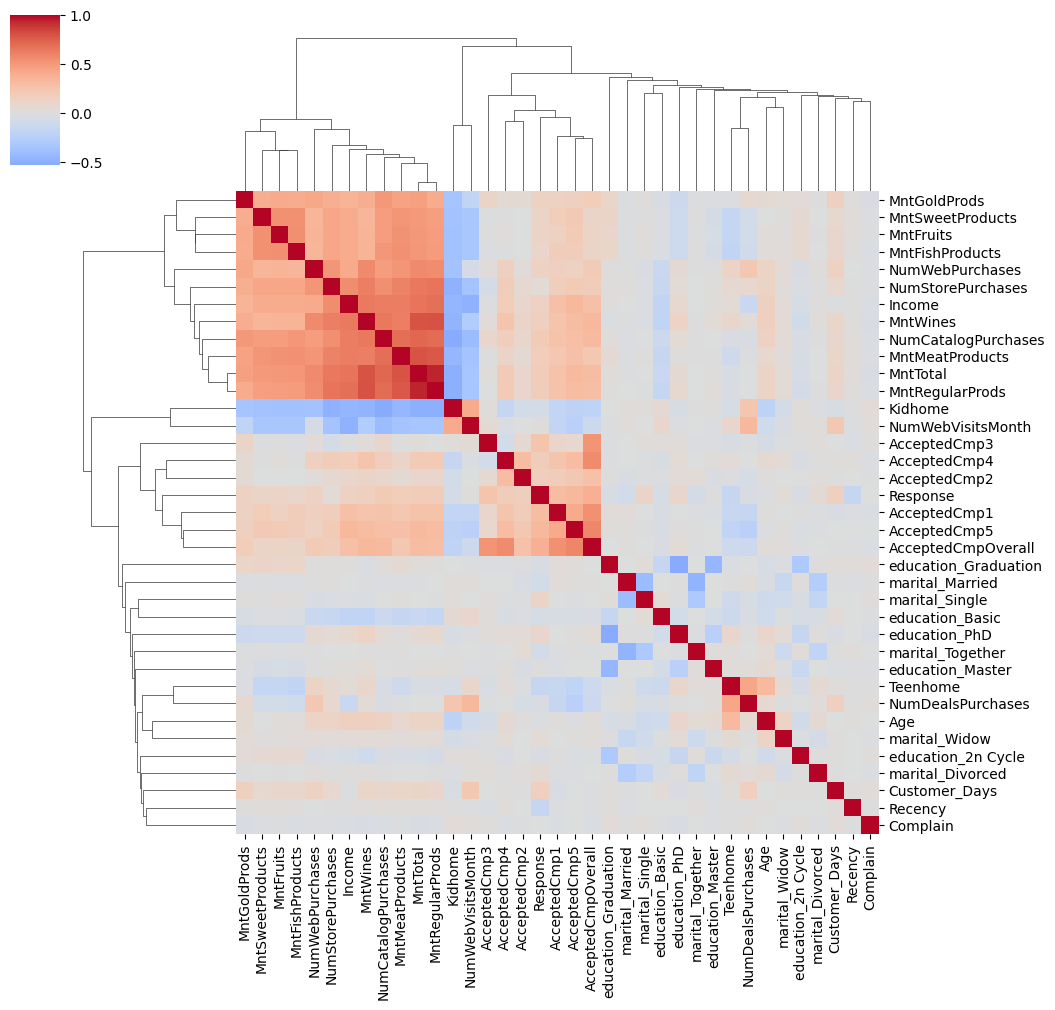

In [20]:
# Using non-parametric test of correlation (kendall), since some features are binary
corrs = food_df.drop(columns=['Z_CostContact', 'Z_Revenue'],axis=1).\
select_dtypes(np.number).corr(method='kendall')
# plot clustered heatmap of correlations
corr_plot =sns.clustermap(corrs, cmap='coolwarm', center=0, cbar_pos=(-0.05, 0.85,0.05,0.15))
corr_plot.savefig('corr_plot.png')
plt.show()

## Create new features
Create following new features
* Dependents: A feature to evaluate how many dependents in a household which sums together the Kidhome and Teenhome
* InRelationship: A feature to identify the in-relationship status which treats marital_Togther, marital_Married as 2 and others as 1
* FamilyNumber: To evaluate the number in a household through summing together the dependents and in_relationship
* NumRegularPurchaseTotal: To get the total regular purchase number(exclude NumDealsPurchases) through summing together the NumWebPurchases, 'NumCatalogPurchase','NumStorePurchase'
* WeightedAffordability: To identify the customer's purchase affordability through setting different weights for income and age and get (income_weight * Income)/(age_weight*age)y
* CustVal: To evaluate the customer's life value as (MnTotal+MntRegularProds+MntGoldProds)/Customer_Days
* CustPurcFrq: To evaluate the customer's purchase frequency as (NumRegularPurchaseTotal+ NumDealsPurchases) /Customer_Days
* AgeGroup: Set the age bins as '0-17', '18-34', '35-44','45-54','55-64','65-74','75+' s

In [21]:
food_df_processed = food_df.copy()
# A feature to evaluate how many dependents in a household
food_df_processed['Dependents'] = food_df_processed['Kidhome'] + food_df_processed['Teenhome']

# InRelationship: A feature to identify the in-relationship status 
# which treats marital_Togther, marital_Married as 2 and others as 1
# define conditions which seperate together people and single person marital_Together
conditions =[
    (food_df_processed['marital_Together']==1)|(food_df_processed['marital_Married']==1), # together people
    (food_df_processed['marital_Divorced']==1)|(food_df_processed['marital_Single']==1)| \
     (food_df_processed['marital_Widow']==1)  # single person
     ]

# Define together people as 2 and single person as 1
choice = [2,1]
food_df_processed['InRelationship']=np.select(conditions,choice,default=0)
# food_df_processed[[ 'InRelationship',*mar_cols,]].sample(5)

# FamilyNumber: To evaluate the number in a household through 
# summing together the dependents and in_relationship
food_df_processed['FamilyNumber'] = food_df_processed['InRelationship'] + \
                                    food_df_processed['Dependents']
# food_df_processed[[ 'FamilyNumber','InRelationship','Dependents','Kidhome',
#                    'Teenhome',*mar_cols,]].sample(5)

# NumRegularPurchaseTotal: To get the total regular purchase number(exclude NumDealsPurchases) through
# summing together the NumWebPurchases, NumCatalogPurchases, NumStorePurchases
food_df_processed['NumRegularPurchaseTotal'] = food_df_processed['NumWebPurchases'] + \
                                     food_df_processed['NumCatalogPurchases'] +\
                                     food_df_processed['NumStorePurchases']
# food_df_processed[[ 'NumRegularPurchaseTotal','NumWebPurchases','NumCatalogPurchases',
#                    'NumStorePurchases']].sample(5)

# WeightedAffordabiity: To identify the customer's purchase affordability through setting 
# different weights for income and age and get (income_weight * Income)/(age_weight*age)
# set different weights for income and age since Income,age correspondingly 
#play a important and weak role in purchase power and marketing effieiency according to  corrs map
weight_income =0.7
weight_age =0.3
food_df_processed['WeightedAffordability'] = round((food_df_processed['Income']*weight_income)/\
                                            (food_df_processed['Age'] *weight_age))

# food_df_processed[['Income','Age','WeightedAffordabiity']].sample(5)

# CustVal: To evaluate the customer's life value as TotalAmount/Customer_Days
food_df_processed['MntTotalGoldRegular'] = food_df_processed['MntTotal'] + \
food_df_processed['MntRegularProds'] + food_df_processed['MntGoldProds']
food_df_processed['CustVal'] = (food_df_processed['MntTotalGoldRegular'])/ \
(food_df_processed['Customer_Days']+0.00001)                               

# food_df_processed[['MntTotal','Customer_Days','CustVal']].sample(5)

# CustPurcFrq: To evaluate the customer's purchase frequency as
# (NumRegularPurchaseTotal + NumDealsPurchases) /Customer_Days

food_df_processed['CustPurcFrq'] = (food_df_processed['NumRegularPurchaseTotal'] + 
                                    food_df_processed['NumDealsPurchases'])/\
                              (food_df_processed['Customer_Days']+0.00001)
food_df_processed[['CustPurcFrq','NumRegularPurchaseTotal',
                   'NumDealsPurchases','Customer_Days']].sample(5)

# AgeGroup: Set the age bins as '0-17', '18-34', '35-44','45-54','55-64','65-74','75+' 
# creat age bins
bins =[0,17,34,44,54,64,74,100]
labels =['0-17', '18-34', '35-44','45-54','55-64','65-74','75+']
food_df_processed['AgeGroup'] = pd.cut(food_df_processed['Age'],
                                       bins=bins, labels=False, right=True)
food_df_processed['AgeGroup'].value_counts()

AgeGroup
3    675
2    498
4    485
5    337
1    187
6     23
Name: count, dtype: int64

In [22]:
food_df_processed.drop(['Z_CostContact','Z_Revenue','Age'],axis=1, inplace=True)
print(food_df_processed.columns)
food_df_processed.sample()

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Customer_Days',
       'marital_Divorced', 'marital_Married', 'marital_Single',
       'marital_Together', 'marital_Widow', 'education_2n Cycle',
       'education_Basic', 'education_Graduation', 'education_Master',
       'education_PhD', 'MntTotal', 'MntRegularProds', 'AcceptedCmpOverall',
       'Dependents', 'InRelationship', 'FamilyNumber',
       'NumRegularPurchaseTotal', 'WeightedAffordability',
       'MntTotalGoldRegular', 'CustVal', 'CustPurcFrq', 'AgeGroup'],
      dtype='object')


Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
1248  45579.0        0         1       10       145          1   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
1248               33                2                 1             1   

      NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
1248                  1                4                    1   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
1248                  4                  6             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
1248             0             0             0         0         0   

      Customer_Days  marital_Divorced  marital_Married  marital_Single  \
1248           2472                 0                1               0   

      marital_Together  marital_Widow  education_2n Cycle  education_Basic  \
1248                 0              0                   0                0   

      education_Graduation  education_Master  education_PhD  MntTotal  \
1248                     0                 0              1       182   

      MntRegularProds  AcceptedCmpOverall  Dependents  InRelationship  \
1248              181                   0           1               2   

      FamilyNumber  NumRegularPurchaseTotal  WeightedAffordability  \
1248             3                        9                 1477.0   

      MntTotalGoldRegular   CustVal  CustPurcFrq  AgeGroup  
1248                  364  0.147249     0.004045         5

## Correlation Analysis - After Feature Engineering
From the following heatmap, the relationships between the newly added features and other variables in the dataset are following:

1. **Dependents**:
    - Negatively correlated with most purchasing behavior variables (`MntWines`, `MntMeatProducts`, etc.), indicating that households with more dependents tend to spend less on these categories.

2. **InRelationship**:
    - Shows weak or no significant correlation with most other variables.

3. **FamilyNumber**:
    - Negatively correlated with most purchasing behavior variables, similar to `Dependents`.

4. **NumRegularPurchaseTotal**:
    - Positively correlated with most purchasing behavior variables (`MntWines`, `MntMeatProducts`, etc.), indicating that customers who make more regular purchases also tend to spend more on these categories.

5. **WeightedAffordability**:
    - Positively correlated with most purchasing behavior variables, indicating that higher affordability is associated with higher spending.

6. **CustVal**:
    - Positively correlated with most purchasing behavior variables, indicating that higher customer value is associated with higher spending.

7. **CustPurcFrq**:
    - Positively correlated with most purchasing behavior variables, indicating that higher purchase frequency is associated with higher spending.

8. **AgeGroup**:
    - Shows weak or no significant correlation with most other variables, indicating that age groups do not have a strong direct relationship with other features in the dataset.

Overall, the newly added features except Inrelationship and AgeGroup provide additional insights into customer behavior and their relationships with other variables in the dataset. These features help in understanding the impact of household composition, purchasing behavior, and affordability on customer spending and response to marketing campaigns.


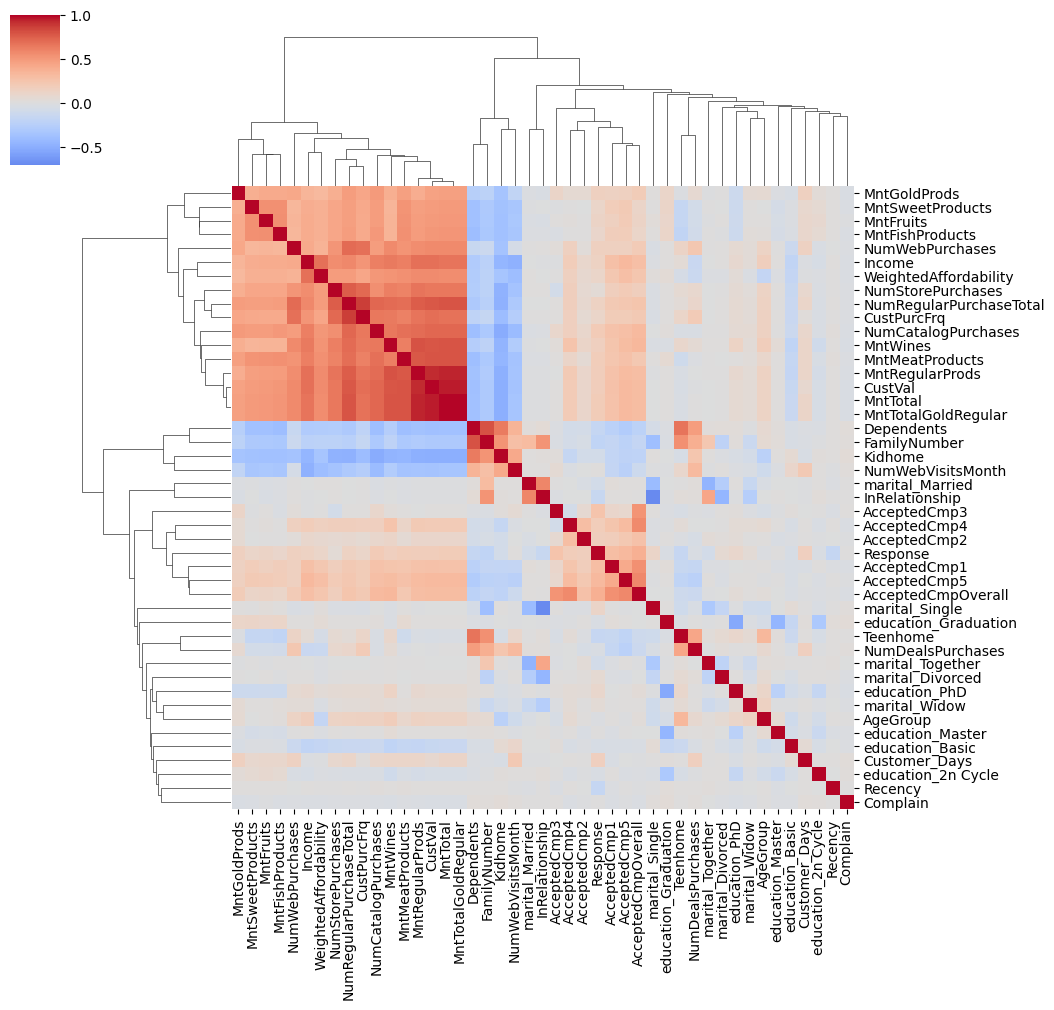

In [23]:
# Cluster correlation heatmap of all columns
corrs = food_df_processed.corr(method='kendall')
# set xticklabels and yticklabels as true to show all features' name
sns.clustermap(data=corrs, cmap='coolwarm',center=0,
               cbar_pos=(-0.05, 0.85,0.05,0.15),
              xticklabels= True, yticklabels = True);

# Data EDA

EDA here focus on Marketing performance, specifically the `Response` variable. During the analysis, I found The `Response` has a strong positive correlations with products spending, `Income` and `Customer-Day`. At the same time `Response` shows a negative correlations with the customer's family size, `Recency`, and `NumDealPurchase`.Interestingly, the `Complain` has no correlation with `Response` 


**EDA Procedures**
* Exploring what features impact the Response 
    * Calculate/visualize the mutual importance between features and `Response` variable to capture both linear and nolinear relationship
    * Since some features are categorical ones, not all features are normally distributed and outliers exist, I use non-parametric testing(Kendall Tau corrlation) to assess both the direction and strength of the correlation, assuming a monotonic relationship between features and `Response`
    * Using random forest to identify the feature importance between `Response` and other features, incorporating permutation tests and SHAP for deeper insights
* Exploring `Response` among customers groups with different products spending
* Exploring `Response` of different marketing channels


In [24]:
# Cluster the columns to make the analysis more clear
mkt_cols = [col for col in food_df.columns if ('Accep' in col) or (col=='Response') ]
mnt_cols = [col for col in food_df.columns if ('Mnt' in col)]
edu_cols = [col for col in food_df.columns if ('edu' in col)]
mar_cols = [col for col in food_df.columns if ('mari' in col)]
num_cols = [col for col in food_df.columns if ('Num' in col)]
mkt_cols.remove('AcceptedCmpOverall')
[col for col in food_df.columns if (col not in mar_cols+mkt_cols+edu_cols+mnt_cols+num_cols)]

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Age',
 'Customer_Days',
 'AcceptedCmpOverall']

In [25]:
# The 'Kidhome', 'Teenhome' are 2 independent columns
display(food_df[[ 'Kidhome', 'Teenhome',]].sample(5))
food_df[[ 'Kidhome', 'Teenhome',*mar_cols]].sample(5)

Kidhome  Teenhome
222         1         0
626         0         0
2001        0         0
879         1         0
307         0         1

Kidhome  Teenhome  marital_Divorced  marital_Married  marital_Single  \
1545        0         0                 0                0               1   
2073        1         0                 0                1               0   
882         0         0                 0                0               0   
839         0         0                 0                1               0   
1516        1         1                 0                0               0   

      marital_Together  marital_Widow  
1545                 0              0  
2073                 0              0  
882                  1              0  
839                  0              0  
1516                 1              0

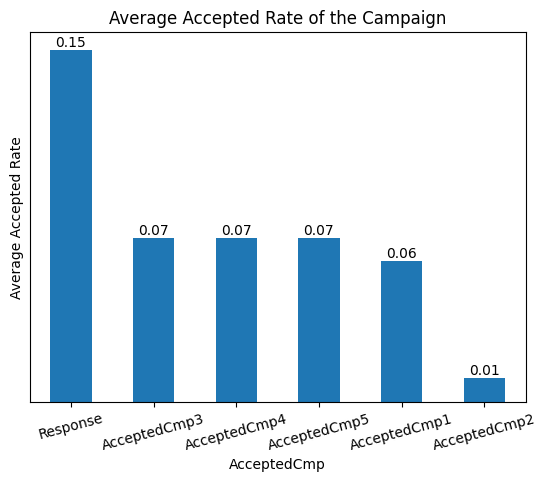

In [26]:
# Compare Average Accepted Rate of the Campaign
# The response campaign have the best accepted rate and campaign 2 had the worst
campaign_accpt_rate =pd.melt(food_df,value_vars=mkt_cols, var_name='AcceptedCmp').groupby('AcceptedCmp').\
mean().round(2)
ax= campaign_accpt_rate.sort_values(by='value', ascending=False).plot(kind='bar',legend=False)
ax.bar_label(ax.containers[0], padding=0.05)
plt.title('Average Accepted Rate of the Campaign')
plt.ylabel('Average Accepted Rate')
# Hide y ticks
plt.yticks([])

plt.xticks(rotation=15);

In [27]:
# Drop previous compaign columns and marital columns which have been processed to new columns
drop_cols = ['Response','AcceptedCmpOverall','AcceptedCmp1', 'AcceptedCmp2'
              , 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', *mar_cols]

0.82

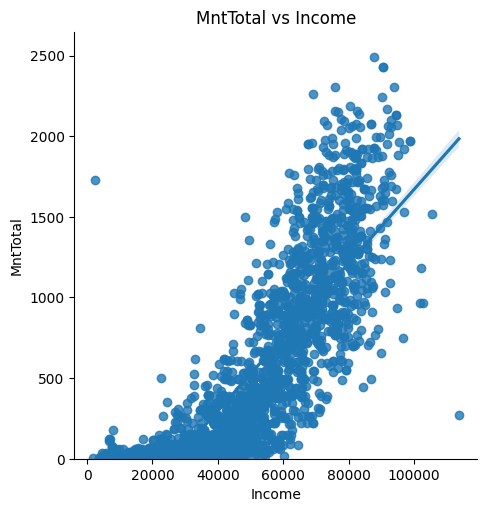

In [28]:
# explore correlation between MntTotal and the Income
# There is a strong linear relationship between MntTotal and Income
sns.lmplot(data= food_df, y= 'MntTotal', x='Income')
plt.ylim(0,)
plt.title('MntTotal vs Income')
food_df['MntTotal'].corr(food_df['Income']).round(2)

## Feature Importance Analysis

### Mutual importance
Calculate the mutual importance between features and response. Mutual information regression captures both linear and non-linear relationships between the features and the target variable response.It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.   
From the Mutual importance analysis, there exist important relationship between the Response and MntTotal, CusVal, NumStorePurchase,  MntRegualarProds,CustPurcFrq, MntTotalGoldRegular, MntWines and Income 

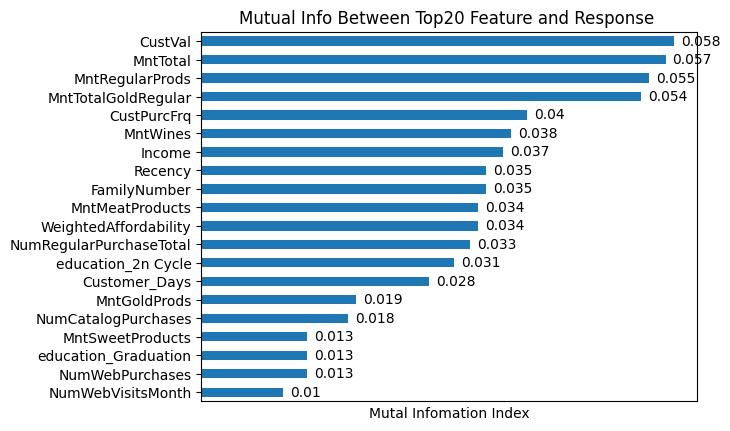

In [29]:
mutual_info = mutual_info_regression(food_df_processed.drop(drop_cols, axis=1),
                                     food_df_processed['Response'],random_state=42)
feature_importance = pd.Series(mutual_info, index= food_df_processed.drop(drop_cols, axis=1).\
                               columns)
feature_importance.sort_values(ascending=False,inplace =True)
ax = round(feature_importance[:20],3).plot.barh()
# Invert the y-axis to ensure the largest values appear at the top
ax.invert_yaxis()
ax.bar_label(ax.containers[0],padding=5)
plt.title('Mutual Info Between Top20 Feature and Response ')
plt.xlabel('Mutal Infomation Index')
plt.xticks([]);

### Kendall Correlation
Findings from Kendall Tau corrlation

* The customers who purchase more especially in meat, regular products, wine and with catelog channel have **positive** correlation with `Response`
* The Customer_Days has **positive** correlation with the  `Response`
* Customer with PHD has **positive** correlation with response while the customers with other education backgroud have negative correlation with response. This may potentially relate to their `income` since `Income` also has **Positive** correlation with `Response`
* The household with more family members and like deals purchase have negative relationship with `Response`.
* The customer's recency has negative correlation with the `Response`
* The `complain` has no impact to `Response`
Considering all above, it seems the final campaign mainly focus on the customers with higher purchase power or attracts the attention of higher purchase power customers. Company may design another campaign to attact the price sensitive customers if they want to cover the household with more family members. Also alternative campaign can focus on attracting those who recently haven't purchased the goods.

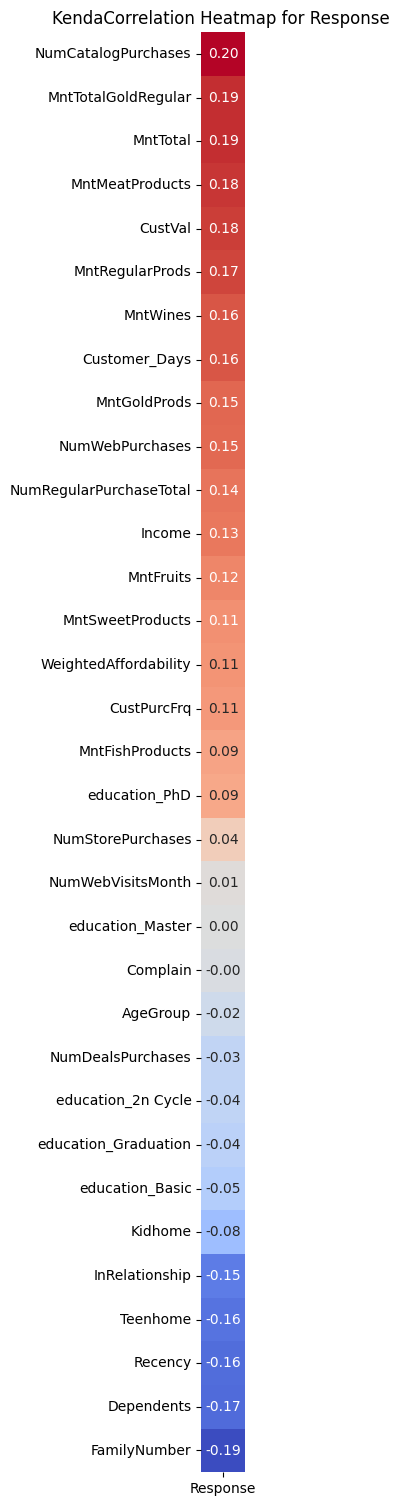

In [30]:
# Kendall correlation especially for Response
response_corrs = corrs['Response'].drop(drop_cols)
plt.figure(figsize=(10,18))
sns.heatmap(pd.DataFrame(response_corrs.sort_values(ascending=False)), cmap='coolwarm',
              annot=True, square=True, fmt='.2f',cbar=False,
           # cbar_kws ={'shrink':0.5, 'aspect':25}
           )
plt.subplots_adjust(left=0.3, right=0.5, top=0.9, bottom=0.1)
# Set the title 
plt.title('KendaCorrelation Heatmap for Response ')
plt.show()

### Random Forest
Using random forest to identify feature importance between the `Response` and other features, along with permutation methods to get deeper insights

From the Random Forest model's importan features, I can see that `Recency`, `Customer_Days` and `Income` and spending on certain products are the most important features for predicting `Response`

ROC AUC Score:  0.66
Classification_report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       374
           1       0.70      0.34      0.46        67

    accuracy                           0.88       441
   macro avg       0.79      0.66      0.70       441
weighted avg       0.86      0.88      0.86       441



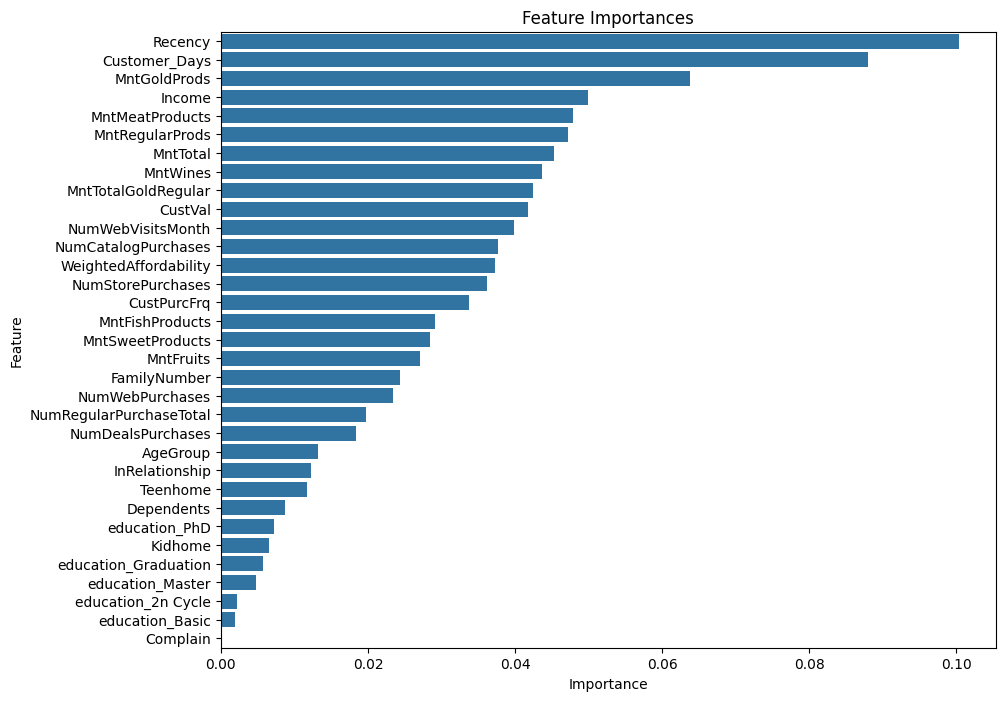

In [36]:
# Seperate the data into X and y
X = food_df_processed.drop(drop_cols, axis=1)
y = food_df_processed['Response']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the random forest classifier
rf = RandomForestClassifier(random_state=42)

#Resample the minority class by oversampling,Tried but not good
X_train_maj, y_train_maj = X_train[y_train==0], y_train[y_train==0]
X_train_min, y_train_min = X_train[y_train==1], y_train[y_train==1]

# Upsample the minority class
X_train_min_upsampled, y_train_min_upsampled = resample(X_train_min, y_train_min,
                                                        replace=True,
                                                        n_samples = len(X_train_maj),
                                                        random_state=42)

# Combine the upsampled minority class with the majority class
X_train_resampled = pd.concat([X_train_maj, X_train_min_upsampled])
y_train_resampled = pd.concat([y_train_maj, y_train_min_upsampled])

#Using Resample to balance the data
# smote =SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the hyperparameters to tune the model
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=100, cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_resampled, y_train_resampled)
# Get the best model from the RandomizedSearchCV
best_rf = random_search.best_estimator_
# param_grid = {
#     'n_estimators': [200, 300,400],
#     'max_depth': [10, 20, 30, 40, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
    
#     # 'class_weight': ['balanced']
# }

# # Initialize the GridSearchCV
# grid_search = GridSearchCV(rf, param_grid=param_grid, cv=3, n_jobs=-1)
# grid_search.fit(X_train_resampled, y_train_resampled)
# # Get the best model from the GridSearchCV
# best_rf = grid_search.best_estimator_


# Fit the model
# rf.fit(X_train, y_train)
# rf.fit(X_train_resampled, y_train_resampled)
# Get the predictions
y_pred = best_rf.predict(X_test)
# Evaluate the model
print("ROC AUC Score: ", round(roc_auc_score(y_test, y_pred),2))
print("Classification_report:\n",classification_report(y_test, y_pred))

# Get the feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
# Sort values by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
#  Plot the feature importance
plt.figure(figsize=(10,8))
sns.barplot(data=feature_importances_df, x='Importance', y='Feature')
plt.title('Feature Importances')
plt.show()

In [37]:
best_rf

RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=266,
                       random_state=42)

The permutation importances highlights the most influential features in predicting the response variable, with family size, recency and spending on specific product categories(like meat and fish) being the most significant predictors 

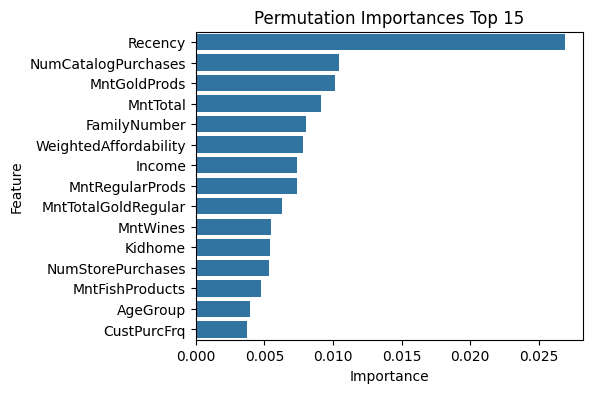

In [38]:
# using purmutation importance in sklearn to evaluate the feature importance


# Get the permutation importance
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=42)
# Get the feature importance
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
# Sort values by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
#  Plot the feature importance
plt.figure(figsize=(5,4))
sns.barplot(data=perm_importance_df[:15], x='Importance', y='Feature')
plt.title('Permutation Importances Top 15')
plt.show()


In [39]:
# Using PermutationImportance in eli5 to evaluate the feature importance
# Get the permutation importance
perm = PermutationImportance(best_rf, random_state=42).fit(X_test, y_test)
# show the feature importance
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=15)

The customer has final response has comparabaly higher customer Days,Income, Amount in purchase and less recency.

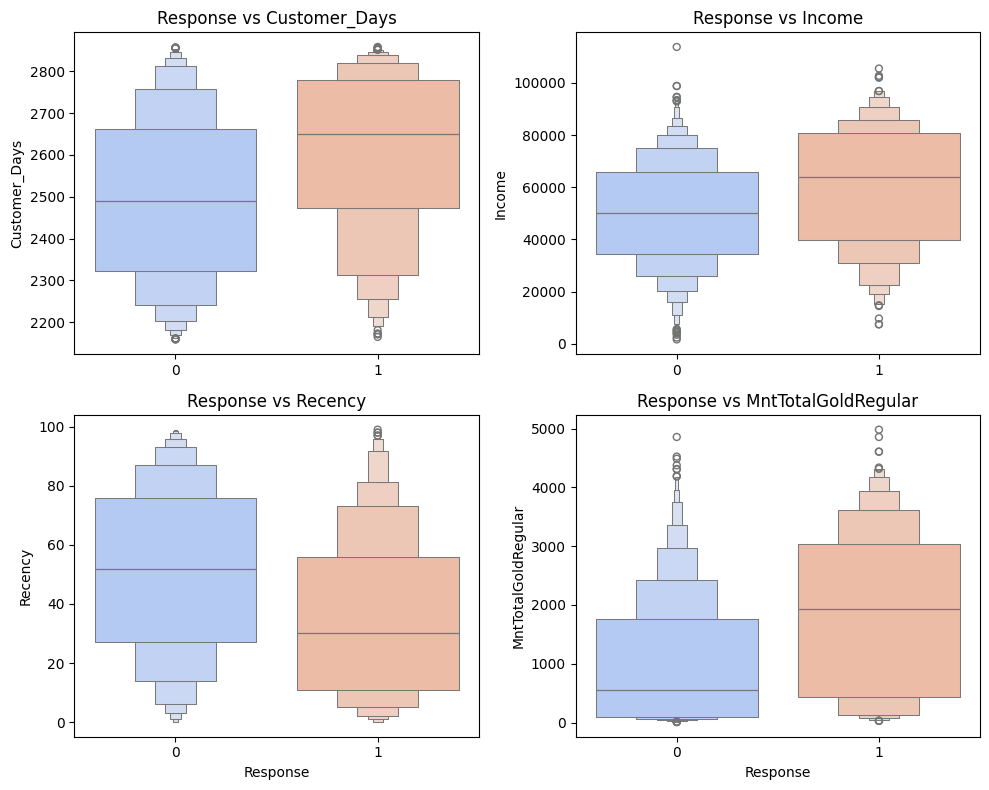

In [40]:
# plot the Response vs FamilyNumber, Customer_Days, Income, Recency and MntAll in 3*2 grid plots
fig, ax = plt.subplots(2,2, figsize=(10,8))
ax = ax.flatten()
for i,col in enumerate(['Customer_Days','Income','Recency','MntTotalGoldRegular']):
    sns.boxenplot(data=food_df_processed, x='Response',y=col, ax=ax[i], palette='coolwarm')
    ax[i].set_title(f'Response vs {col}')
    if i <=1:
        ax[i].set_xlabel('')
plt.tight_layout()


## Response VS Different Amount of Product 
The descriptive statistics table, combined with the histograms and boxen plots, provides a more complete picture of the data. The Combination indicates that customers who are spend more on different products are more likely to respond to a campaign  
**General Patterns:**

* **Higher Amount in Products Correlate with Response**: In wines, fruits, meat, Fish products and all other purchase product amount plots, customers who responded to the campaign (Response = 1) tend to have higher purchase amounts  than those who did not respond (Response = 0). This is a strong trend.

* **Different Products Matter**: Focus on the differences in purchase behavior across Products. The combination shows that Wines, meats, gold and regular products are more different between the groups than other products.

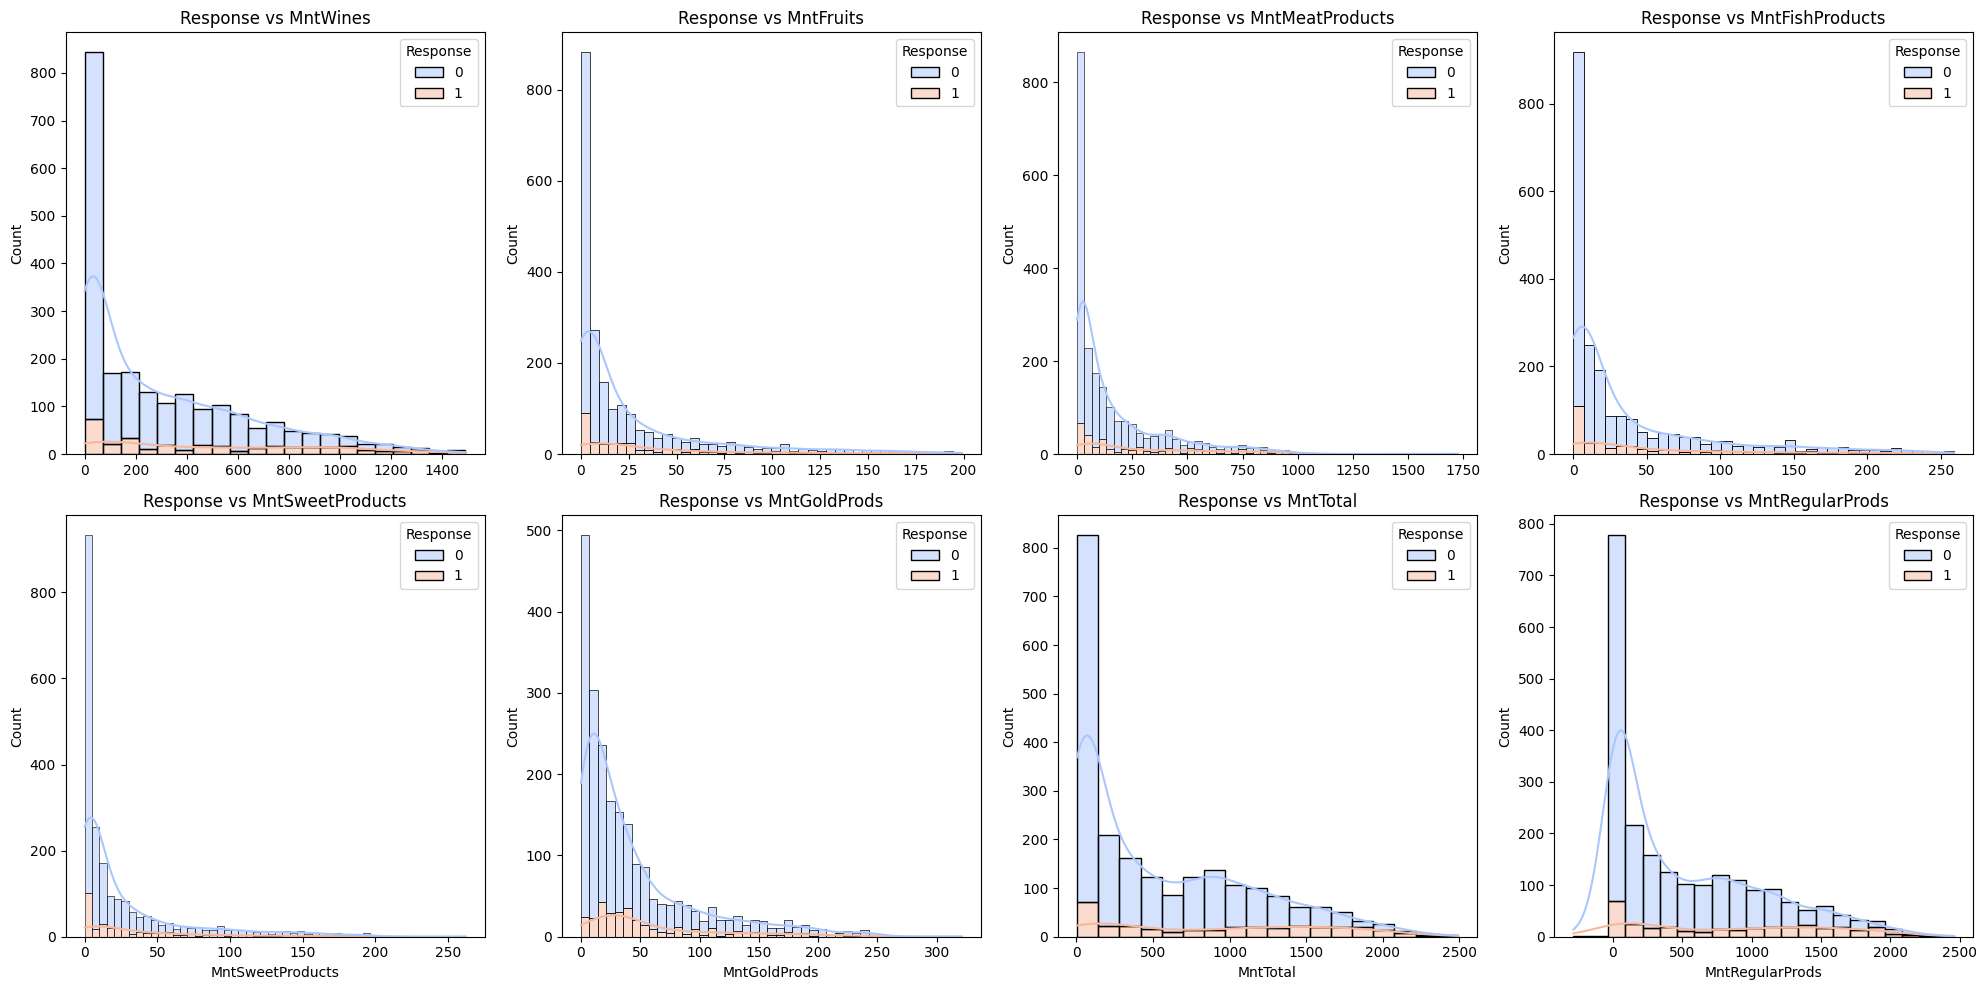

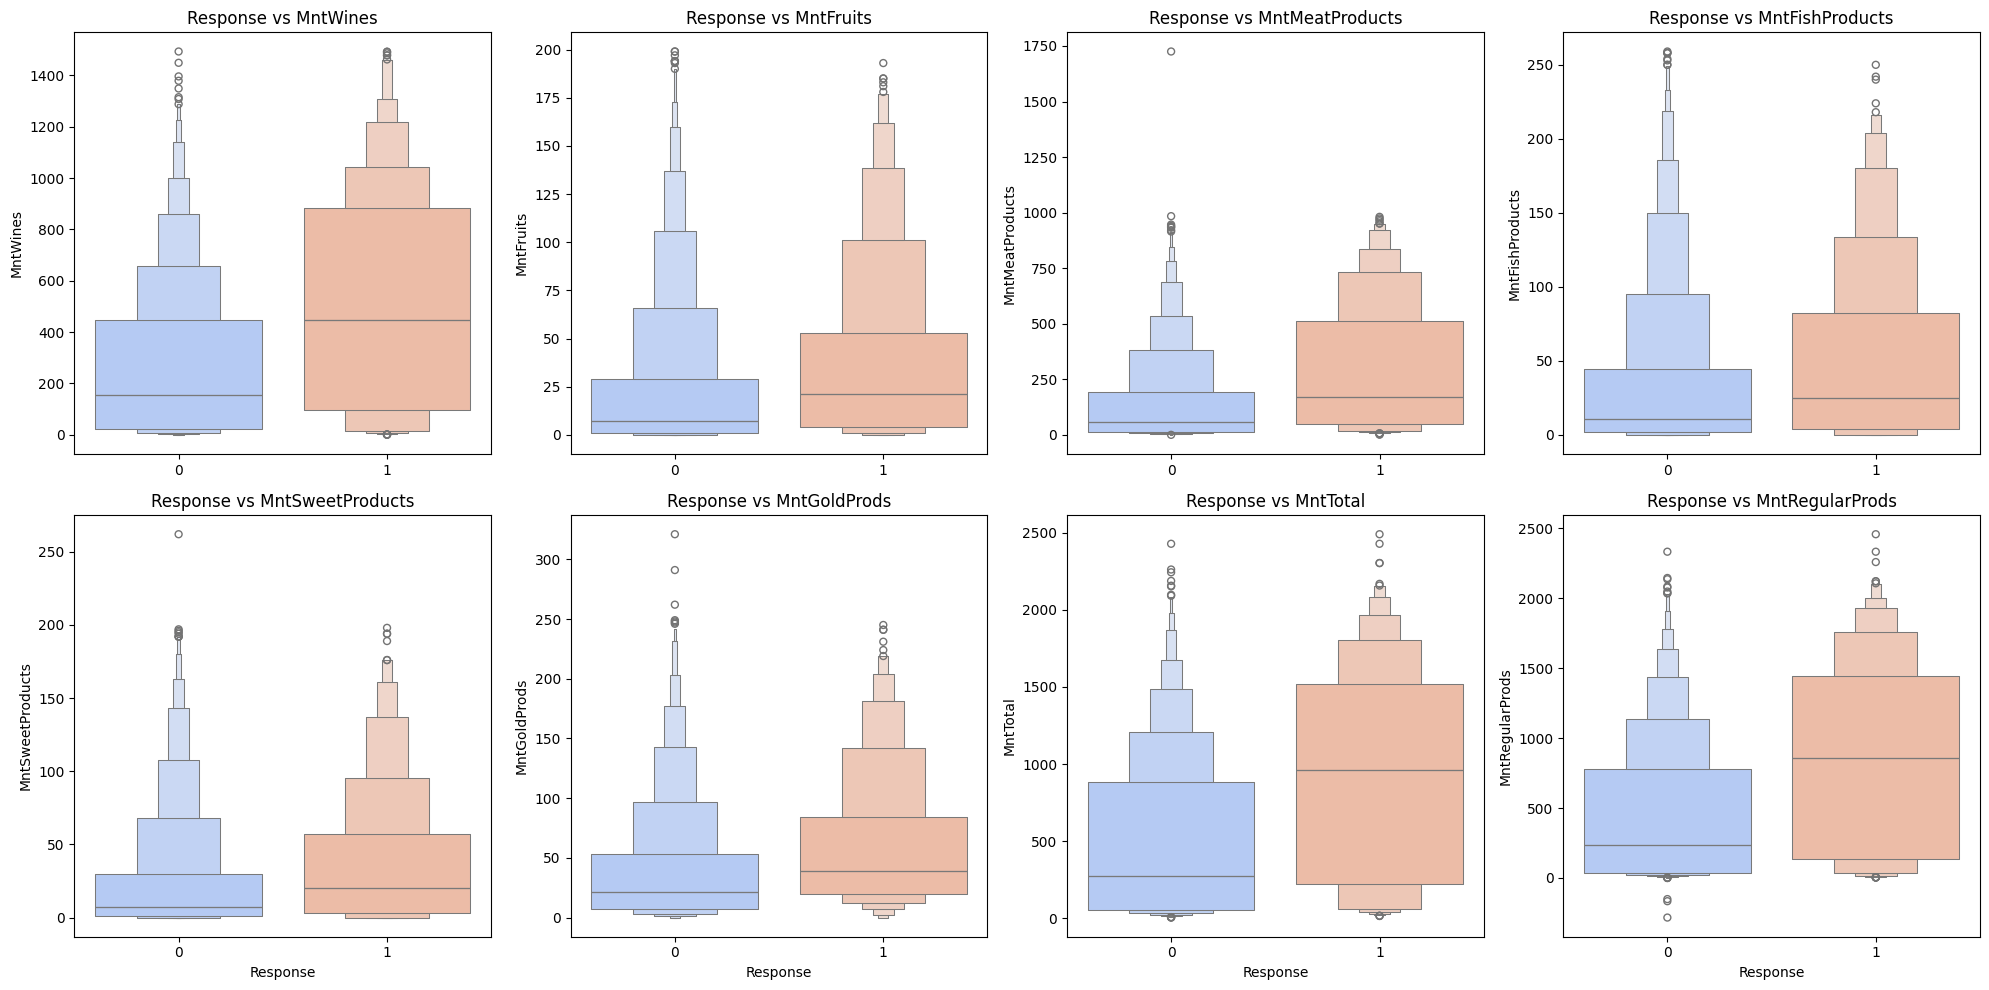

In [41]:
# plot the Response vs MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts,MntRegualrProds, MntGoldProds in 2*4 grid plots
_, ax = plt.subplots(2,4, figsize =(20,10))
ax = ax.flatten()
# Hist stack plot can show the distribution of each product purchase amount
for col in mnt_cols:
    sns.histplot(data=food_df_processed, hue='Response', x=col,\
                  ax = ax[mnt_cols.index(col)], palette='coolwarm',kde=True, multiple='stack')
    ax[mnt_cols.index(col)].set_title(f'Response vs {col}')
    if mnt_cols.index(col) <=3:
        ax[mnt_cols.index(col)].set_xlabel('')

plt.tight_layout()
plt.show()

# plot the Response vs MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts,MntRegualrProds, MntGoldProds in 2*4 grid plots
_, ax = plt.subplots(2,4, figsize =(20,10))
ax = ax.flatten()

for col in mnt_cols:
    sns.boxenplot(data=food_df_processed, x='Response', y=col,\
                  ax = ax[mnt_cols.index(col)], palette='coolwarm')
    ax[mnt_cols.index(col)].set_title(f'Response vs {col}')
    if mnt_cols.index(col) <=3:
        ax[mnt_cols.index(col)].set_xlabel('')

plt.tight_layout()
plt.show()



In [42]:
food_df_processed.groupby('Response')[mnt_cols].describe()

MntWines                                                            \
            count        mean         std  min   25%    50%     75%     max   
Response                                                                      
0          1872.0  271.219017  305.949986  0.0  22.0  154.5  446.25  1493.0   
1           333.0  502.615616  427.823621  1.0  96.0  448.0  882.00  1492.0   

         MntFruits                                                     \
             count       mean        std  min  25%   50%   75%    max   
Response                                                                
0           1872.0  24.350962  38.242723  0.0  1.0   7.0  29.0  199.0   
1            333.0  37.939940  45.916005  0.0  4.0  21.0  53.0  193.0   

         MntMeatProducts                                                    \
                   count        mean         std  min   25%    50%     75%   
Response                                                                     
0                 1872.0  142.462073  194.381835  0.0  14.0   57.0  193.25   
1                  333.0  293.765766  287.120466  1.0  47.0  170.0  512.00   

                 MntFishProducts                                               \
             max           count       mean        std  min  25%   50%    75%   
Response                                                                        
0         1725.0          1872.0  35.273504  53.156355  0.0  2.0  11.0  44.25   
1          981.0           333.0  51.714715  61.642623  0.0  4.0  25.0  82.00   

                MntSweetProducts                                              \
            max            count       mean        std  min  25%   50%   75%   
Response                                                                       
0         259.0           1872.0  25.128205  39.854742  0.0  1.0   7.0  30.0   
1         250.0            333.0  38.372372  46.148458  0.0  3.0  20.0  57.0   

                MntGoldProds                                               \
            max        count       mean        std  min   25%   50%   75%   
Response                                                                    
0         262.0       1872.0  40.998397  50.046707  0.0   7.0  21.0  53.0   
1         198.0        333.0  61.252252  57.484645  0.0  20.0  39.0  84.0   

                MntTotal                                                       \
            max    count        mean         std   min    25%    50%      75%   
Response                                                                        
0         321.0   1872.0  498.433761  525.968943   4.0   50.0  273.0   883.25   
1         245.0    333.0  924.408408  698.913637  14.0  219.0  964.0  1517.00   

                 MntRegularProds                                               \
             max           count        mean         std    min    25%    50%   
Response                                                                        
0         2429.0          1872.0  457.435363  503.757790 -283.0   38.0  239.0   
1         2491.0           333.0  863.156156  682.672587    3.0  136.0  858.0   

                           
              75%     max  
Response                   
0          780.25  2333.0  
1         1441.00  2458.0

Amount of products and Income shows exponent relationship especailly in MnTotal, MntRegular,MntWine and MntMeat

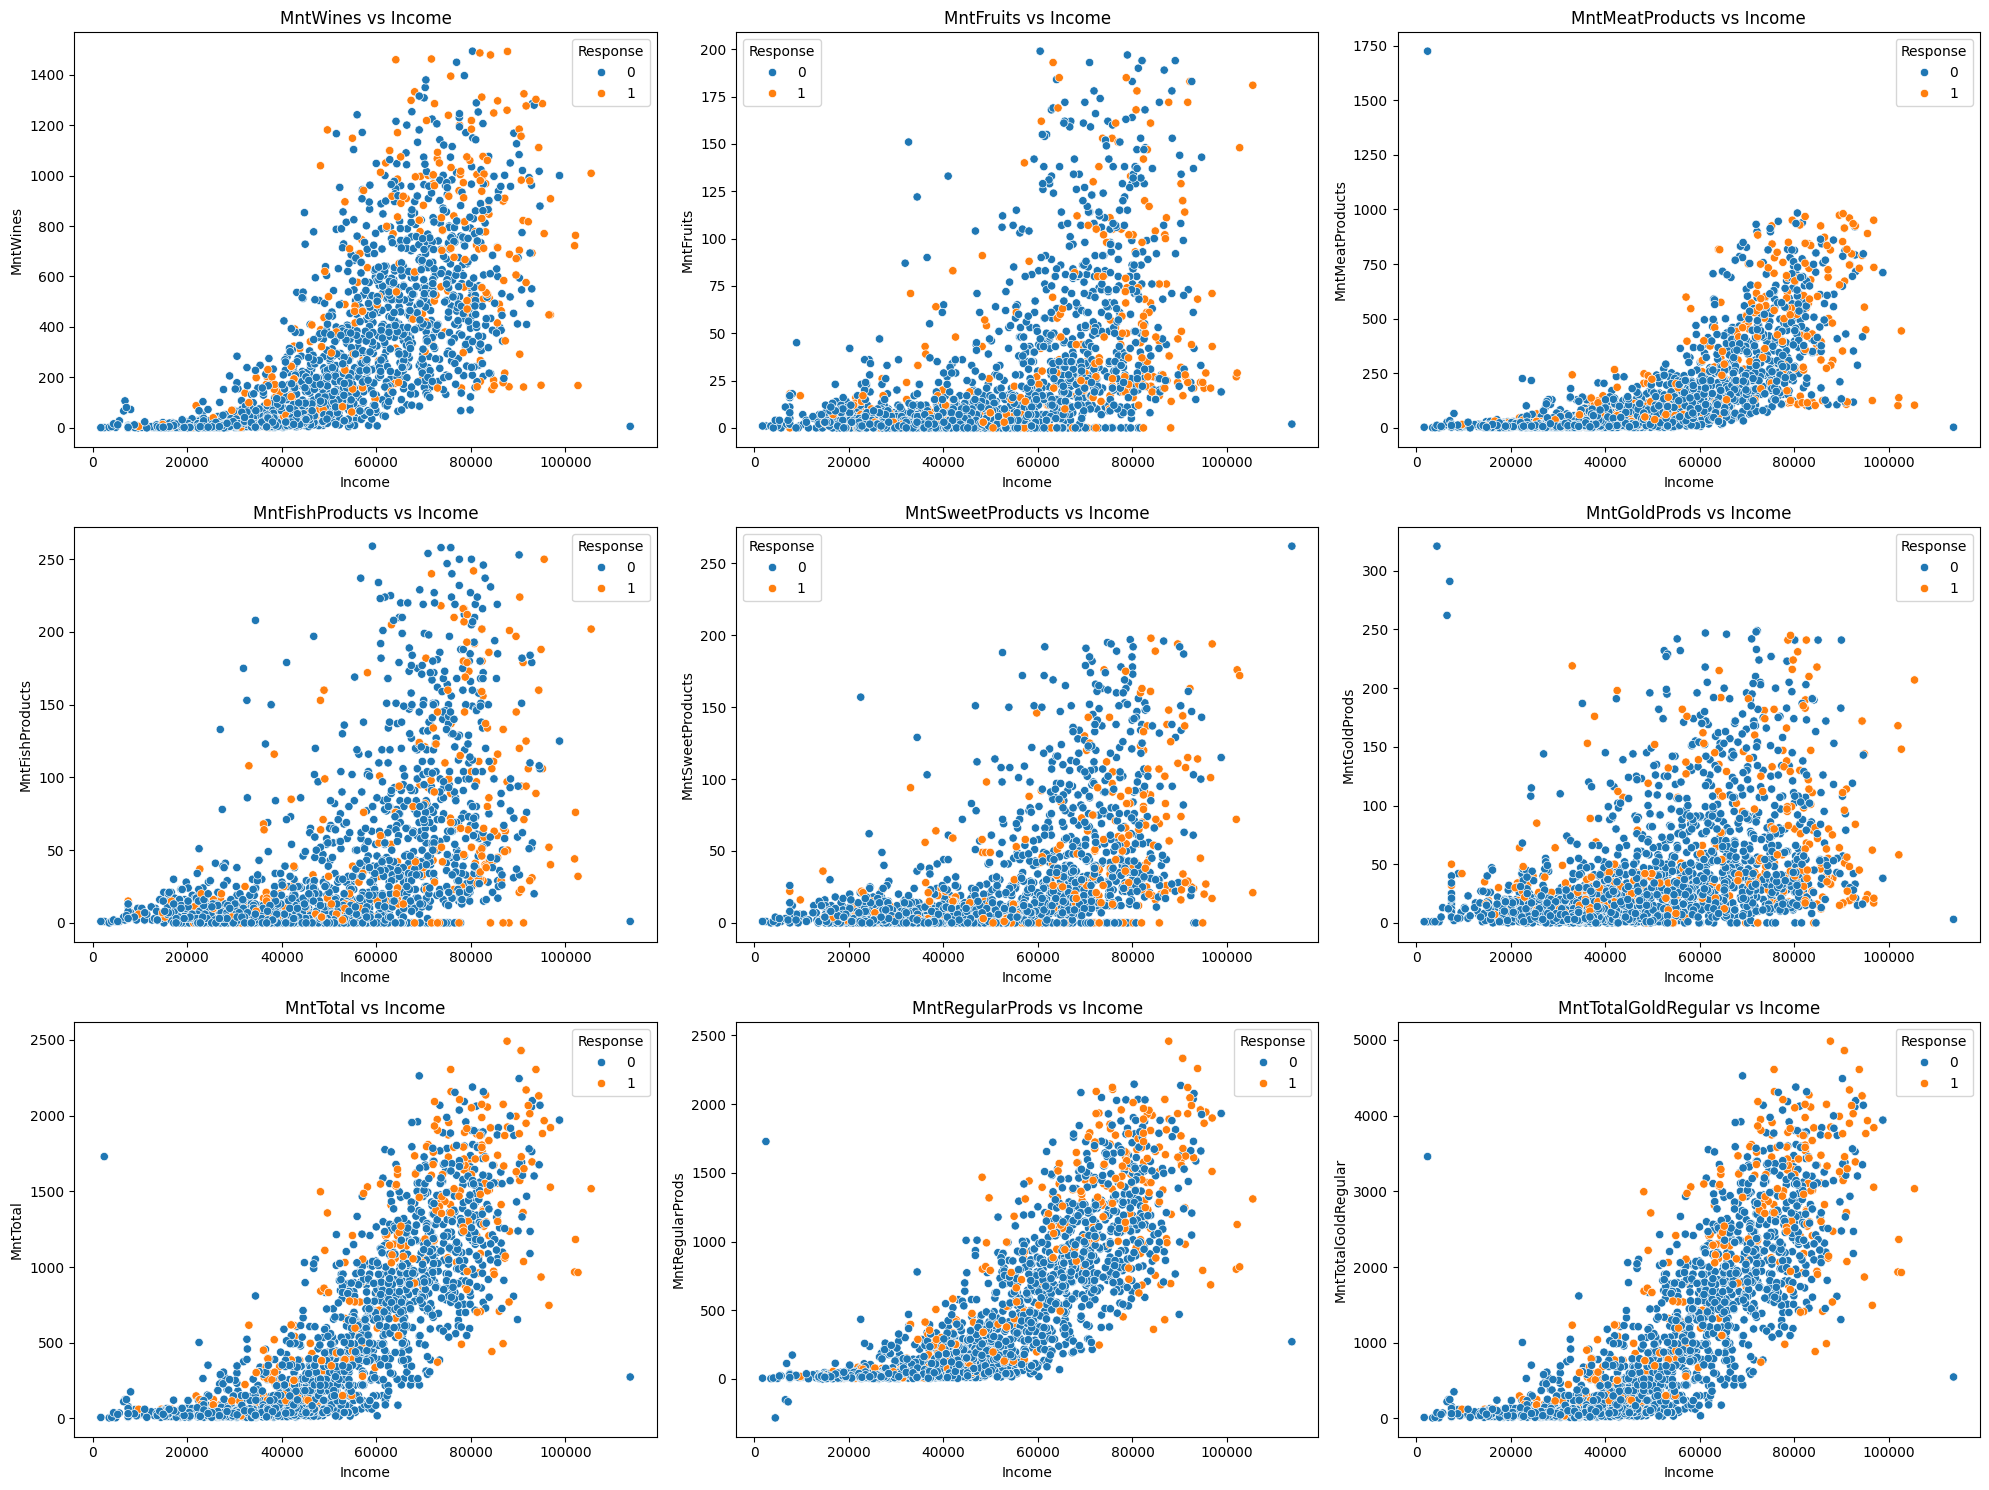

In [43]:
# Plot the relationship between amount of different products and income in 3*3 grid plots
fig, ax =plt.subplots(3,3, figsize=(20,15))
ax = ax.flatten()
for i, col in enumerate([*mnt_cols, 'MntTotalGoldRegular']):
    sns.scatterplot(data=food_df_processed, x='Income',y=col, ax=ax[i],hue='Response')
    ax[i].set_title(f'{col} vs Income')
plt.tight_layout()

In [44]:
# merge different binary education level columns into one column 
# edu_cols = [col for col in food_df.columns if ('edu' in col)]
food_df_processed['Education']= food_df_processed[edu_cols].idxmax(axis=1)\
    .str.replace('education_','')

# check the updated columns
food_df_processed[['Education',*edu_cols]].sample(5)

Education  education_2n Cycle  education_Basic  education_Graduation  \
487       Master                   0                0                     0   
40    Graduation                   0                0                     1   
1731      Master                   0                0                     0   
896       Master                   0                0                     0   
2017      Master                   0                0                     0   

      education_Master  education_PhD  
487                  1              0  
40                   0              0  
1731                 1              0  
896                  1              0  
2017                 1              0

Customers with PHD education background have higher response rate even they are not the biggest proportion of the customer population and then followed by master and graduation. I need to test whether there really exists statistic difference between different education later.

Text(0.5, 1.0, 'Education Level Distribution')

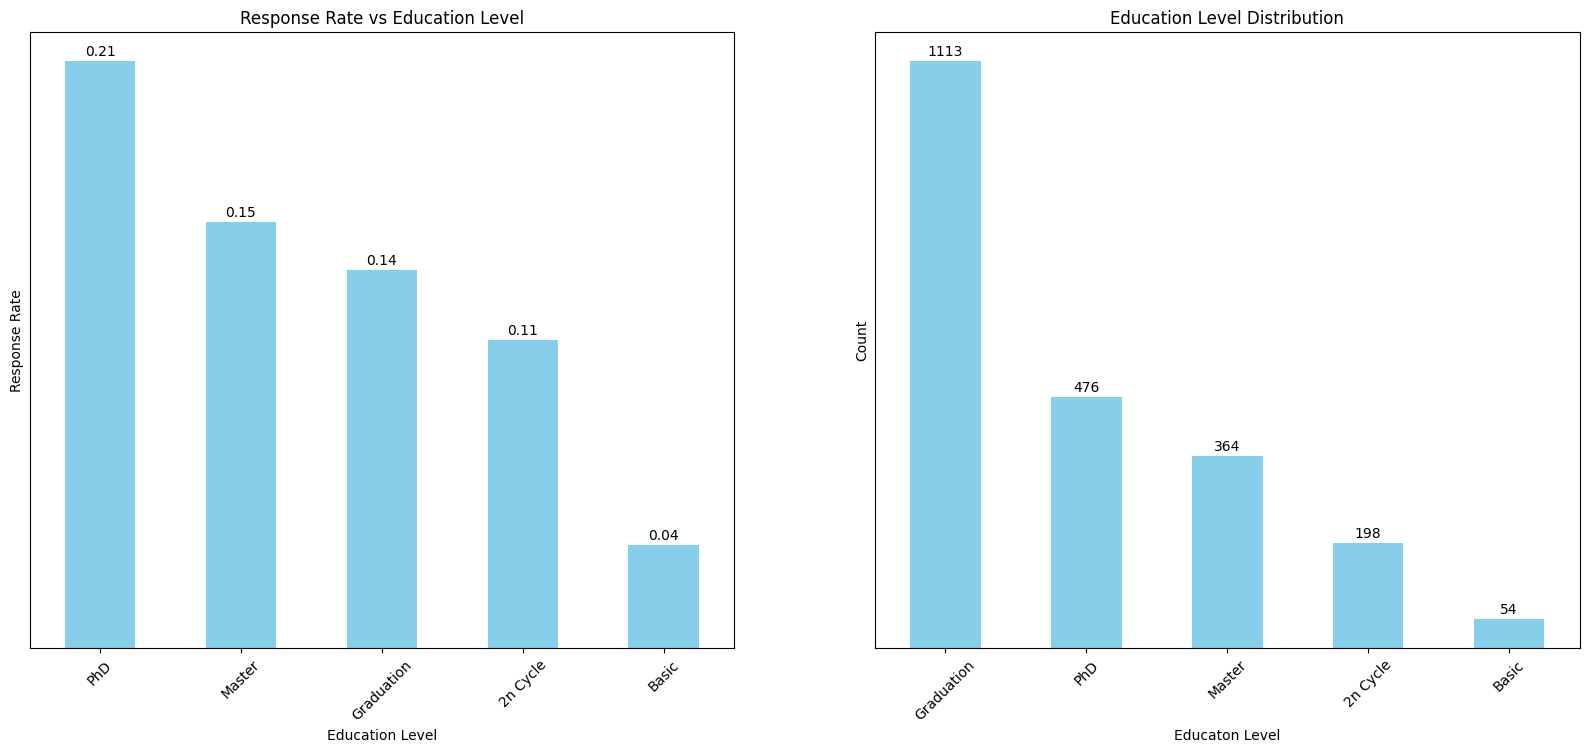

In [45]:
# plot different education level response rate and education level distribution
fig,ax = plt.subplots(1,2, figsize=(20,8))

# plot different education level response rate
# plt.figure(figsize=(10,6))
food_df_processed.groupby('Education')['Response'].mean().\
    sort_values(ascending=False)\
    .plot(kind='bar', color='skyblue', width=0.5, ax=ax[0])
#set bar labels with 2 decimal places
ax[0].bar_label(ax[0].containers[0],fmt='%.2f', padding=2)
ax[0].set_ylabel('Response Rate')
ax[0].set_xlabel('Education Level')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_yticks([])
ax[0].set_title('Response Rate vs Education Level')

#plot education level distribution
food_df_processed['Education'].value_counts().plot(kind='bar',\
                                                   color='skyblue',width=0.5,\
                                                    ax=ax[1])
ax[1].bar_label(ax[1].containers[0], padding=2)
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Educaton Level')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_yticks([])
ax[1].set_title('Education Level Distribution')

## Response of Different Channels
The Combination of descriptive statistics, histograms, and boxen plots indicates that customers who are more engaged with the brand through different channels (web, catalog, store)  are more likely to respond to a campaign  
**General Patterns:**

* **Higher Purchase Numbers Correlate with Response**: In web, catalog and store purchase plots, customers who responded to the campaign (Response = 1) tend to have higher purchase counts  than those who did not respond (Response = 0). This is a strong trend.

* **Deal Purchases Less Informative**: Deal purchases seem to be the least informative indicator of response, as the difference between the two groups is less pronounced.

* **NumWebVisitsMonth**: The description table shows that the mean and median are very similar for both groups, indicating that this variable, while showing a difference in the boxen plot, might not be a strong predictor.

* **Different Channels Matter**: Focus on the differences in purchase behavior across channels, The combination shows that web and catalog purchases are more different between the groups than store purchases.

Next Step:

* Statistical Testing:

Since there exists outliers, Non-parametric tests (Mann-Whitney U) are used to test the statistics significance.  Additionally, consider using effect size measures (e.g., Cliff's delta) to quantify the practical significance of the differences, especially when the means are close but medians are different. The table shows that the mean can be misleading.

* Customer Segmentation:

Use the 25th, 50th, and 75th percentiles to create meaningful segments, and consider segmenting based on a combination of medians for different features. Also, consider using clustering algorithms based on medians and IQR.

* Focus on Medians and IQR: 
The table reinforces the importance of focusing on medians and IQRs rather than means and standard deviations, as the means can be misleading in the presence of skewed distributions and outliers.

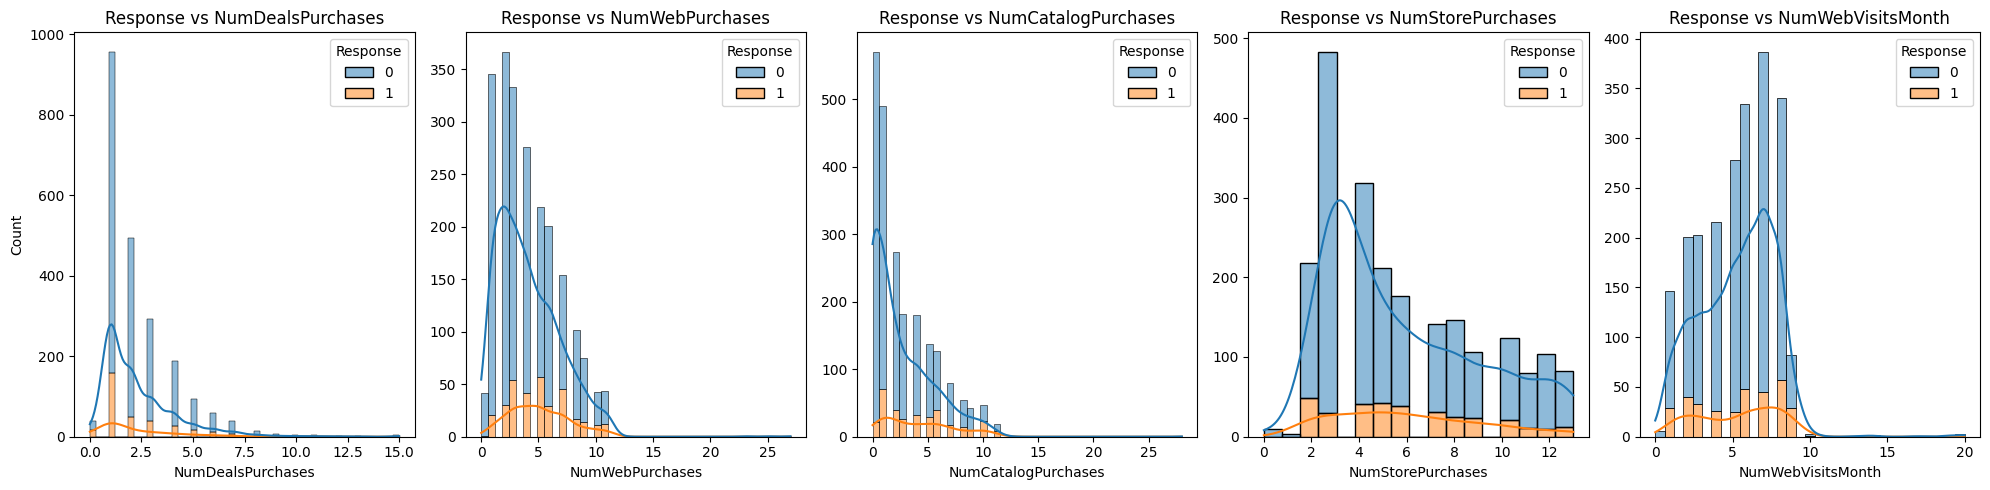

In [46]:
# Explore wheter there exists difference among numbers purchase for those response or not
# num_cols = [col for col in food_df.columns if ('Num' in col)]
 
_, ax = plt.subplots(1,5, figsize=(20,5))
for i, col in enumerate(num_cols):
    # sns.boxenplot(data=food_df_processed, x='Response', y=col, ax=ax[i], palette='coolwarm')
    sns.histplot(data=food_df_processed, x=col, hue='Response', ax=ax[i],kde=True, multiple="stack")
    ax[i].set_title(f'Response vs {col}')
    if i !=0:
        ax[i].set_ylabel('')
plt.tight_layout()


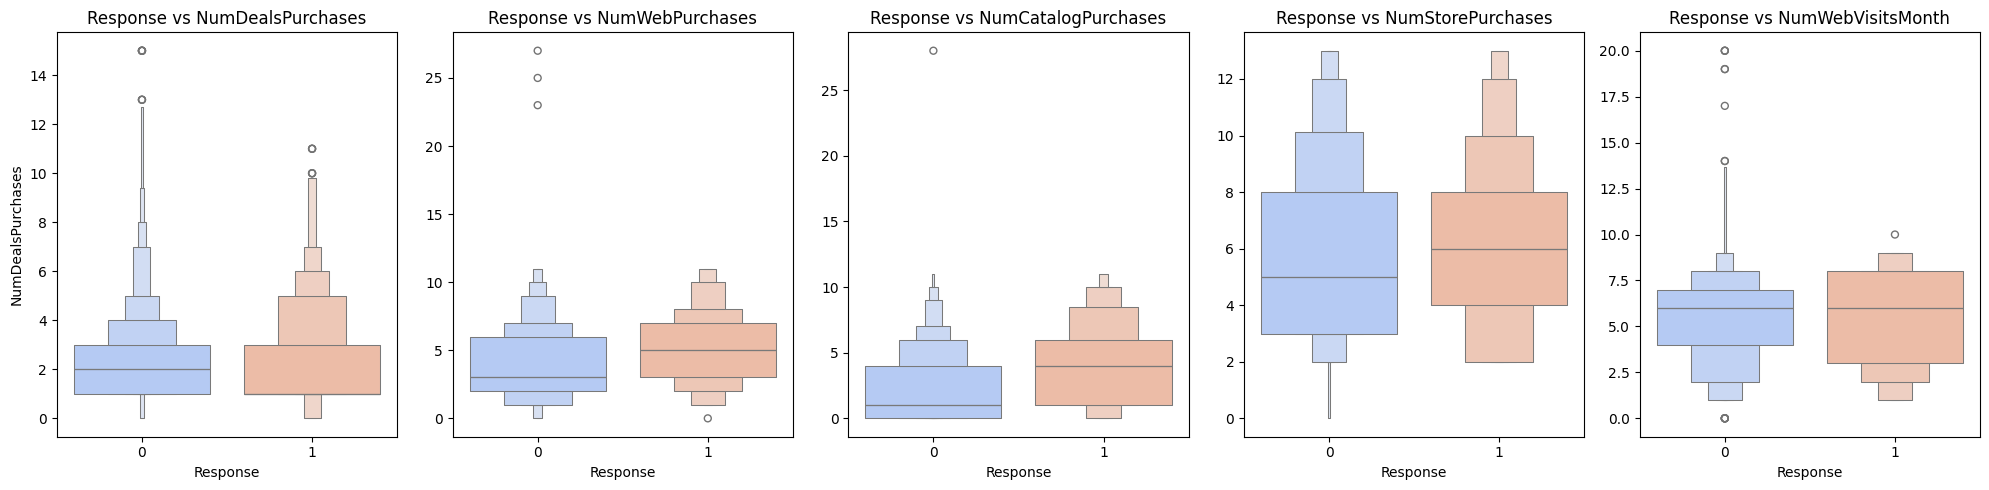

In [47]:
_, ax = plt.subplots(1,5, figsize=(20,5))
for i, col in enumerate(num_cols):
    sns.boxenplot(data=food_df_processed, x='Response', y=col, ax=ax[i], palette='coolwarm')
    ax[i].set_title(f'Response vs {col}')
    if i !=0:
        ax[i].set_ylabel('')
plt.tight_layout()

In [48]:
food_df_processed.groupby('Response')[num_cols].describe()

NumDealsPurchases                                                \
                     count      mean       std  min  25%  50%  75%   max   
Response                                                                   
0                   1872.0  2.314637  1.843659  0.0  1.0  2.0  3.0  15.0   
1                    333.0  2.339339  2.111825  0.0  1.0  1.0  3.0  11.0   

         NumWebPurchases                                                \
                   count      mean       std  min  25%  50%  75%   max   
Response                                                                 
0                 1872.0  3.927885  2.732044  0.0  2.0  3.0  6.0  27.0   
1                  333.0  5.072072  2.562631  0.0  3.0  5.0  7.0  11.0   

         NumCatalogPurchases                                                \
                       count      mean       std  min  25%  50%  75%   max   
Response                                                                     
0                     1872.0  2.368590  2.640764  0.0  0.0  1.0  4.0  28.0   
1                      333.0  4.201201  3.136224  0.0  1.0  4.0  6.0  11.0   

         NumStorePurchases                                                \
                     count      mean       std  min  25%  50%  75%   max   
Response                                                                   
0                   1872.0  5.777778  3.269276  0.0  3.0  5.0  8.0  13.0   
1                    333.0  6.081081  3.074776  2.0  4.0  6.0  8.0  13.0   

         NumWebVisitsMonth                                                
                     count      mean       std  min  25%  50%  75%   max  
Response                                                                  
0                   1872.0  5.342415  2.386663  0.0  4.0  6.0  7.0  20.0  
1                    333.0  5.306306  2.562917  1.0  3.0  6.0  8.0  10.0

In [49]:
# Using multiple linear regression to understand the impact of multiple marketing channels on the response
# Initialize the model
model = smf.ols('Response ~ NumWebPurchases + NumCatalogPurchases + NumStorePurchases  ',
                data=food_df_processed)

# Fit the model
results = model.fit()
# Get the summary of the model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               Response   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     64.29
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           7.64e-40
Time:                        20:59:02   Log-Likelihood:                -771.55
No. Observations:                2205   AIC:                             1551.
Df Residuals:                    2201   BIC:                             1574.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1097    

In [42]:
num_cols

['NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth']

## Correlation of Income and the Response

* The logistic regression analysis shows that income is statistically significantly associated with the response rate.


In [50]:
# Test whether the response correlate to the income 
# calculate logistic regression p-values for Response ~ Income using generalized linear model
# The positive coefficient (0.0245) of income suggests that higher income increases the 
# likelihood of responding.
# p-value for Income: The p-value for the income variable is less than 0.05 (p = 0.000), 
# so I reject the null hypothesis and conclude that income is statistically significantly 
# associated with the response rate.
import statsmodels.api as sm
# to make the result(coefficient) more interpret, here scale the income to K
X= (food_df_processed['Income']/1000).round(1)
y = food_df_processed['Response']

# Add a constant (intercept) to the model
X = sm.add_constant(X)


# Fit the logistic regression model
model = sm.Logit(y,X)
result =model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.408886
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 2205
Model:                          Logit   Df Residuals:                     2203
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Feb 2025   Pseudo R-squ.:                 0.03673
Time:                        20:59:38   Log-Likelihood:                -901.59
converged:                       True   LL-Null:                       -935.97
Covariance Type:            nonrobust   LLR p-value:                 1.118e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0796      0.188    -16.341      0.000      -3.449      -2.710
Income         0.0245      0.003      8.051      0.000       0.019       0.030
==============================================================================
"""

# Hypothesis testing
Confirm if the observed differences in distributions between the two  groups are statistically significant.
* Eduction level matters: for differenct education level, whether there is statistically significant relationship between education levels and income. 
    * Using point- biserial correlation, I was able to conclude that there is a statistically significant correlation between each education level and income at the 0.05 significance level.
    * In general, the higher education levels generally correspond to higher income,  with the exception of basic education, which is negatively correlated with income
* Channel matters: for web, catalog, and store, whether each channel has statistically significant different between 2 response groups. With Mann Whitney U test and cliff's delta effect size test to get both statitical and practical effect sense 

## Whether Education Level Correlated to the Income
H0: There is no correlation between each education level and income   
Ha: There is a correlation between each education level and income   
Significance Level $\alpha $=0.05

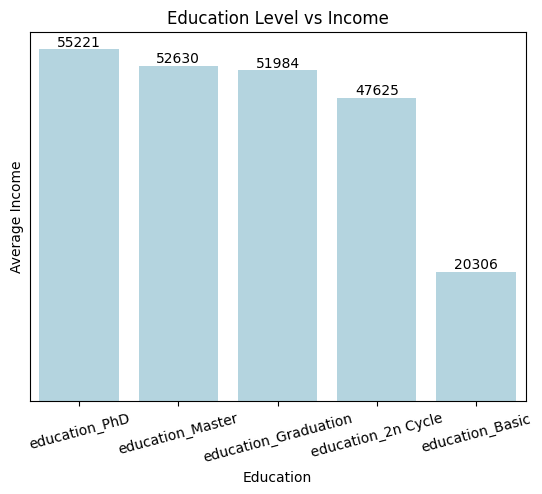

In [51]:
# Check there statistic difference response between the education group and their direction

# It shows higher education level with higher Income level
# check different education with differnt average income 
edu_melted = food_df_processed.melt(id_vars='Income', value_vars=edu_cols,
                       var_name = 'Education', value_name ='has_education')
edu_melted = edu_melted[edu_melted.has_education==1]
edu_income_avg =edu_melted.groupby(['Education']).Income.mean().\
                sort_values(ascending=False).round(0).reset_index()
ax =sns.barplot(data = edu_income_avg, x='Education',y='Income', errorbar=None,color='lightblue'
            )
plt.bar_label(ax.containers[0])
plt.yticks([])
plt.xticks(rotation=15)
plt.ylabel('Average Income')
plt.title('Education Level vs Income');



Since the education level data is imbalanced, the original dataset shows weak or no statistcal signicant differences between education levels and income. However, after upsampling the minor class, I was able to reject the null Hypothesis and conclude that there is a statistically significant correlation between each education level and income at the 0.05 significance level.

In [52]:
# Using statistic testing to test whether there really exists the significant difference in income between different education level
# If The p-value for the education variable is less than 0.05, 
# I would reject the null hypothesis and conclude that education is significantly associated with income.

# calculate point-biserial correlation coefficient between education and income
print("The original dataset education distribution:\n ",food_df_processed[edu_cols].sum(axis=0))
for col in edu_cols:
    pb_corr = pointbiserialr(food_df_processed[col], food_df_processed['Income'])
    print(f"Original: Point-Biserial Correlation between {col} and Income is {pb_corr.correlation:.2f} with p-value {pb_corr.pvalue:.3f}")

The original dataset education distribution:
  education_2n Cycle       198
education_Basic           54
education_Graduation    1113
education_Master         364
education_PhD            476
dtype: int64
Original: Point-Biserial Correlation between education_2n Cycle and Income is -0.06 with p-value 0.004
Original: Point-Biserial Correlation between education_Basic and Income is -0.24 with p-value 0.000
Original: Point-Biserial Correlation between education_Graduation and Income is 0.02 with p-value 0.408
Original: Point-Biserial Correlation between education_Master and Income is 0.02 with p-value 0.310
Original: Point-Biserial Correlation between education_PhD and Income is 0.09 with p-value 0.000


Education matters significantly for income, with higher education levels generally linked to higher income, while lower education levels show a negative or minimal association.

In [53]:
# Since the education level data is imbalanced, I will perform data upsampling  to obtain more meaningful results and then test the relationship between education level and income
from sklearn.utils import resample
# Upsample the minority class
edu_df = food_df_processed[edu_cols].copy()
# Upsample the minority class
edu_df['Income'] = food_df_processed['Income']
upsampled_edu = pd.DataFrame()
majority_count = food_df_processed[edu_cols].sum(axis=0).max()
for col in edu_cols:
    # Separate minority classes    
    minority = edu_df[edu_df[col]==1]
    # Upsample the minority class
    minority_upsampled = resample(minority, replace=True, n_samples=majority_count, random_state=42)
    # Combine the majority class with the upsampled minority class
    upsampled_edu = pd.concat([upsampled_edu,  minority_upsampled])
# Calculate the point-biserial correlation coefficient between education and income
for col in edu_cols:
    pb_corr = pointbiserialr(upsampled_edu[col], upsampled_edu['Income'])
    print(f"Upsampled: Point-Biserial Correlation between {col} and Income is {pb_corr.correlation:.2f} with p-value {pb_corr.pvalue:.3f}")

Upsampled: Point-Biserial Correlation between education_2n Cycle and Income is 0.05 with p-value 0.001
Upsampled: Point-Biserial Correlation between education_Basic and Income is -0.56 with p-value 0.000
Upsampled: Point-Biserial Correlation between education_Graduation and Income is 0.14 with p-value 0.000
Upsampled: Point-Biserial Correlation between education_Master and Income is 0.15 with p-value 0.000
Upsampled: Point-Biserial Correlation between education_PhD and Income is 0.23 with p-value 0.000


In [54]:
upsampled_edu[edu_cols].sum(axis=0)

education_2n Cycle      1113
education_Basic         1113
education_Graduation    1113
education_Master        1113
education_PhD           1113
dtype: int64

## Whether there is  difference in product's amount between response and non-response groups  
Since there exists outliers and the product's acount distributions are non-normal distribution, here using non-parametric tests, Mann-whitney U test and cliffs Delta, to test the Hypothesis   
The null hypothesis and alternative hypothesis for each product are:
H0: There is no difference in product's amount between response and non-response groups    
Ha: There is difference in product's amount between response and non-response groups    
Significance level $\alpha=0.05$ 

In [55]:
def cliffs_delta(group1, group2):
    """
    This function calculates the Cliff's Delta effect size.

    Args:
    group1: array_like, the first group of data.
    group2: array_like, the second group of data.

    Returns:
    float: The Cliff's Delta effect size.
    """
    group1 = np.array(group1)
    group2 = np.array(group2)
    # Calculate the number of instances in each group
    n1, n2 = len(group1), len(group2)

    # Handle empty arrays
    if n1 == 0 or n2 == 0:
        return 0
    
    # Calculate the number of difference instances between the two groups
    diffs = np.subtract.outer(group1, group2)

  

    # Calculate the Cliff's Delta effect size
    return np.sum(np.sign(diffs)) / (n1 * n2)


def perform_mannwhitneyu_with__effect_size(df, feature, target ='Response'):
    """
    This function performs the Mann-Whitney U test and calculates
      the Cliff's Delta effect size.

    Args:
    df: pd,DataFrame, the dataframe containing the data.
    feature: str, column name of the feature to test.
    target: str, column name of the target variable.

    Returns:
    dict: Dictionary containing test statistics, p-value of the Mann-Whitney U test, 
      Cliff's Delta effect size. and iterpretation.
    """
    # Separate the data into two groups
    group1 = df[df[target] == 1][feature]
    group2 = df[df[target] == 0][feature]


    # Perform the Mann-Whitney U test
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    

    # Calculate the Cliff's Delta effect size
    effect_size = cliffs_delta(group1, group2)
    abs_effect_size = abs(effect_size)
  

    # Interpret the effect size
    effect_size_interpretation = 'No effect'
    if abs_effect_size >= 0.33:
        effect_size_interpretation = 'Large effect'
    elif abs_effect_size >= 0.147:
        effect_size_interpretation = 'Medium effect'
    elif abs_effect_size > 0:
        effect_size_interpretation = 'Small effect'

   # Interpret the p-value
   # significance level
    alpha = 0.05
    significant = p < alpha


    # Interpret the p-value
    interpretation = f"p-value: {p:.4f} "
    if significant:
        interpretation += f"The difference in distributions is statistically  significant ( p < {alpha})"
    else:
        interpretation += f"The difference in distributions is not statistically significant ( p >= {alpha})"
    interpretation += f"\n Cliff's Delta: {effect_size:.3f} ({effect_size_interpretation})"
 

    return {\
        'statistic': stat,
        'p-value': p,
        'effect_size': effect_size,
        'interpretation': interpretation
        }

There exists significant difference in all products purchase amount, espeically in Meat and regular product pruchase amount are more different between the groups than other products purchases.

In [56]:
results ={}
for col in mnt_cols:
    results[col] = \
    perform_mannwhitneyu_with__effect_size(food_df_processed, col,\
                                            target='Response')
    print(f"Mann-Whitney U test with Cliff's Delta for {col}:")
    print(f" Statistic: {results[col]['statistic']:.2f}")
    print(f" {results[col]['interpretation']}")
    print("-" * 100)


Mann-Whitney U test with Cliff's Delta for MntWines:
 Statistic: 410850.50
 p-value: 0.0000 The difference in distributions is statistically  significant ( p < 0.05)
 Cliff's Delta: 0.318 (Medium effect)
----------------------------------------------------------------------------------------------------
Mann-Whitney U test with Cliff's Delta for MntFruits:
 Statistic: 385062.00
 p-value: 0.0000 The difference in distributions is statistically  significant ( p < 0.05)
 Cliff's Delta: 0.235 (Medium effect)
----------------------------------------------------------------------------------------------------
Mann-Whitney U test with Cliff's Delta for MntMeatProducts:
 Statistic: 423796.50
 p-value: 0.0000 The difference in distributions is statistically  significant ( p < 0.05)
 Cliff's Delta: 0.360 (Large effect)
----------------------------------------------------------------------------------------------------
Mann-Whitney U test with Cliff's Delta for MntFishProducts:
 Statistic: 368160

## Among Channels, whether there is  difference between response and non-response groups  
Since there exists outliers and the each channel's number distributions is non-normal distribution, here using non-parametric tests, Mann-whitney U test and cliffs Delta, to test the Hypothesis   
The null hypothesis and alternative hypothesis for each channel is:
H0: There is no difference in Channel number between response and non-response groups    
Ha: There is difference in Channel number between response and non-response groups    
Significance level $\alpha=0.05$ 

Like what was found in ETA, there exists significant difference in web, catalog and  store purchase. Catalog and Web purchases are more different between the groups than store purchases.

In [57]:
results ={}
for col in num_cols:
    results[col] = \
    perform_mannwhitneyu_with__effect_size(food_df_processed, col,\
                                            target='Response')
    print(f"Mann-Whitney U test with Cliff's Delta for {col}:")
    print(f" Statistic: {results[col]['statistic']:.2f}")
    print(f" {results[col]['interpretation']}")
    print("-" * 100)

Mann-Whitney U test with Cliff's Delta for NumDealsPurchases:
 Statistic: 294057.00
 p-value: 0.0832 The difference in distributions is not statistically significant ( p >= 0.05)
 Cliff's Delta: -0.057 (Small effect)
----------------------------------------------------------------------------------------------------
Mann-Whitney U test with Cliff's Delta for NumWebPurchases:
 Statistic: 396605.00
 p-value: 0.0000 The difference in distributions is statistically  significant ( p < 0.05)
 Cliff's Delta: 0.272 (Medium effect)
----------------------------------------------------------------------------------------------------
Mann-Whitney U test with Cliff's Delta for NumCatalogPurchases:
 Statistic: 426970.00
 p-value: 0.0000 The difference in distributions is statistically  significant ( p < 0.05)
 Cliff's Delta: 0.370 (Large effect)
----------------------------------------------------------------------------------------------------
Mann-Whitney U test with Cliff's Delta for NumStorePurc

# Identify Customer Segments
Based on above analysis, I'll focus on segmentation strategies that are robust to outliers and leverage the information from descriptive statistics, boxen plots, and the Mann-Whitney U test with Cliff's delta

I'll explore two primary segmentation approaches:

1. **Quantile-Based Segmentation**: Segment customers based on the quantile(25th, 50th, and 75th percentiles) of their pruchase and visit behaviors, This aaproach is robust to outliers
2. **Clustering-Based Segmentation**: Use clustering algorithms based on median values and interquartile ranges(IQRs). This approach can capture more complex patterns

## Quantile-Based Segmentaion

In [58]:
# Create a function to do customer segments based on the quantiles(25th, 50th, and 75th) of the df's feature column

def create_segments(df, feature):
    """
    This function creates customer segments based on the quantiles of the feature column.

    Args:
    df: pd.DataFrame, the dataframe containing the data.
    feature: str, the column name of the feature to create segments.

    Returns:
    pd.DataFrame: The dataframe with a new column containing the customer segments.
    """
    # Get the quantiles of the feature column
    quantiles = df[feature].quantile([0.25,  0.75])
    # Create the segments based on the quantiles
    df[f'{feature}_Segment'] = pd.cut(df[feature], bins=[-np.inf, *quantiles, np.inf],
                                      labels=['Low', 'Medium', 'High'])
    return df

In [59]:
# features_to_analysis = [ 'NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
segment_df = food_df_processed[['Response',*num_cols]].copy()
for col in num_cols:
    segment_df = create_segments(segment_df, col)
    print(f"Segment for {col}:\n",segment_df[f'{col}_Segment'].value_counts())


Segment for NumDealsPurchases:
 NumDealsPurchases_Segment
Low       996
Medium    786
High      423
Name: count, dtype: int64
Segment for NumWebPurchases:
 NumWebPurchases_Segment
Medium    1029
Low        755
High       421
Name: count, dtype: int64
Segment for NumCatalogPurchases:
 NumCatalogPurchases_Segment
Medium    1127
Low        571
High       507
Name: count, dtype: int64
Segment for NumStorePurchases:
 NumStorePurchases_Segment
Medium    994
Low       714
High      497
Name: count, dtype: int64
Segment for NumWebVisitsMonth:
 NumWebVisitsMonth_Segment
Medium    1215
Low        556
High       434
Name: count, dtype: int64


In [53]:
segment_df.groupby('Response')[[col for col in segment_df.columns if 'Segment' in col]].describe()

NumDealsPurchases_Segment                  NumWebPurchases_Segment  \
                             count unique  top freq                   count   
Response                                                                      
0                             1872      3  Low  821                    1872   
1                              333      3  Low  175                     333   

                             NumCatalogPurchases_Segment                      \
         unique     top freq                       count unique     top freq   
Response                                                                       
0             3  Medium  847                        1872      3  Medium  959   
1             3  Medium  182                         333      3  Medium  168   

         NumStorePurchases_Segment                      \
                             count unique     top freq   
Response                                                 
0                             1872      3  Medium  816   
1                              333      3  Medium  178   

         NumWebVisitsMonth_Segment                       
                             count unique     top  freq  
Response                                                 
0                             1872      3  Medium  1071  
1                              333      3  Medium   144

## Clustering-Based Segmentation
### Tune the KMeans models
with silouhette methods to decide the right number of cluster

In [61]:
# Since RandomizedSearchCV is used to find the best hyperparameters for the model, and it does not directly support silhouette score,
# I will define a custom function to calculate the silhouette score for the KMeans clustering algorithm.

def silhouette_scorer(estimator, X):
    """
    Custom silhouette scorer for RandomizedSearchCV.

    Args:
    estimator: The estimator.
    X: The data

    Returns:
    float: The silhouette score.
    """
    try:
        labels = estimator.fit_predict(X)
        score = silhouette_score(X, labels)
        return score
    except ValueError:
        # Haddle the case where the number of clusters is less than 2 or greater than the number of samples
        return -1 
# Define a create_cluser_segments function to use KMeans clustering algorithm to create customer segments based on the median values and interquartile ranges of the input feature list of the df  
# The hyperparameters of the KMeans are determined by the silhouette score. 
# The function returns a new dataframe with the customer segments. and plot the silhouette score for different k values.
# The function handles the case where the number of clusters is less than 2 and standardizes the input features.

def create_cluster_segments(df, features):
    """
    This function creates customer segments based on the median values and interquartile ranges of the input feature list.
    The hyperparameters of the KMeans are determined by the silhouette score. 
    The function returns a new dataframe with the customer segments. and plot the silhouette score for different k values.
    The function handles the case where the number of clusters is less than 2 and standardizes the input features.
    
        Args:
    df: pd.DataFrame, the dataframe containing the data.
    features: str, the column name of the feature to create segments.

    Returns:
    pd.DataFrame: The dataframe with a new column containing the customer segments.    
    """
    # Use RobustScaler to scale the data with median and IQR 
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(df[features])

    # Create a dataframe with the scaled features
    scaled_df = pd.DataFrame(scaled_features, columns=features, index= df.index)

    # Handel NaN values
    scaled_df.fillna(0, inplace=True)

    # Using silhouette score to determine the number of clusters and other common hyperparameters
    silhouette_scores = []
    best_score = -1
    best_k = 0

    # Define the Hyperparameter Distributions for RandomizedSearchCV
    param_distributions = {
        'n_clusters': range(2,7),
        'n_init': randint(10, 101),
        'max_iter': randint(100, 1001),
        'tol': [1e-3, 1e-4, 1e-5],
        'init': ['k-means++', 'random'],
    }

    kmeans =KMeans(random_state=42)

    # RandomSearch for  hyperparameter tuning
    random_search = RandomizedSearchCV(kmeans,
                                        param_distributions,
                                        n_iter=10,
                                        scoring= silhouette_scorer,
                                        random_state=42,
                                        n_jobs=-1,
                                        cv=5)
    random_search.fit(scaled_df)

    # Get the best hyperparameters
    best_kmeans = random_search.best_estimator_
    # best_k = random_search.best_params_['n_clusters']
    best_score = random_search.best_score_

    # print the best hyperparameters
    print(f"Best Hyperparameters: {random_search.best_params_}")
    print(f"Best Silhouette Score: {best_score:.2f}")

    # Use best kmeans for analysis
    df['Clusters']=best_kmeans.fit_predict(scaled_df)

    return df

### Segment Through Channels View

In [62]:
segment_df_kmeans = create_cluster_segments(segment_df, num_cols)
segment_df_kmeans.groupby('Clusters')[num_cols].describe()


Best Hyperparameters: {'init': 'k-means++', 'max_iter': 158, 'n_clusters': 3, 'n_init': 69, 'tol': 1e-05}
Best Silhouette Score: 0.39


NumDealsPurchases                                                \
                     count      mean       std  min  25%  50%  75%   max   
Clusters                                                                   
0                    816.0  1.435049  0.799200  0.0  1.0  1.0  2.0   4.0   
1                    378.0  5.486772  2.169498  3.0  4.0  5.0  6.0  15.0   
2                   1011.0  1.846686  0.938313  0.0  1.0  2.0  2.0   4.0   

         NumWebPurchases                                                \
                   count      mean       std  min  25%  50%  75%   max   
Clusters                                                                 
0                  816.0  5.512255  2.494627  1.0  4.0  5.0  7.0  27.0   
1                  378.0  6.264550  2.444908  0.0  4.0  6.0  8.0  11.0   
2                 1011.0  2.152324  1.391823  0.0  1.0  2.0  3.0   9.0   

         NumCatalogPurchases                                                \
                       count      mean       std  min  25%  50%  75%   max   
Clusters                                                                     
0                      816.0  5.214461  2.498458  0.0  3.0  5.0  7.0  11.0   
1                      378.0  2.653439  2.208976  0.0  1.0  2.0  4.0  28.0   
2                     1011.0  0.568744  0.764285  0.0  0.0  0.0  1.0   5.0   

         NumStorePurchases                                                 \
                     count      mean       std  min  25%  50%   75%   max   
Clusters                                                                    
0                    816.0  8.470588  2.798618  0.0  6.0  8.0  11.0  13.0   
1                    378.0  6.907407  2.681976  0.0  5.0  6.0   9.0  13.0   
2                   1011.0  3.281899  1.166640  0.0  3.0  3.0   4.0  11.0   

         NumWebVisitsMonth                                                
                     count      mean       std  min  25%  50%  75%   max  
Clusters                                                                  
0                    816.0  3.323529  1.882626  0.0  2.0  3.0  5.0   9.0  
1                    378.0  6.756614  1.925405  1.0  6.0  7.0  8.0  20.0  
2                   1011.0  6.431256  1.799882  1.0  5.0  7.0  8.0  20.0

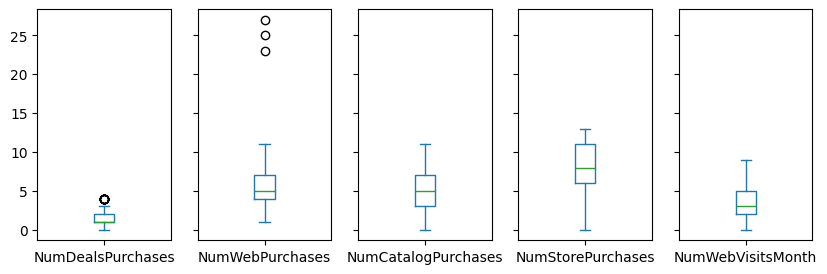

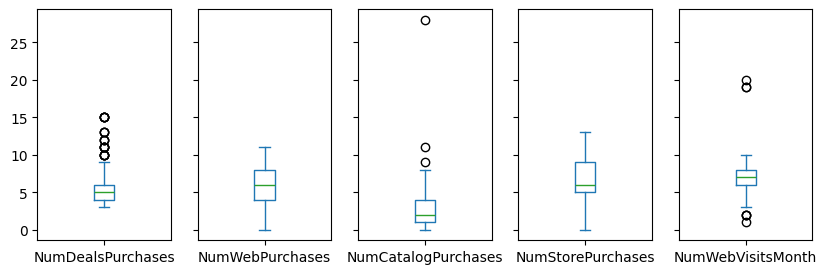

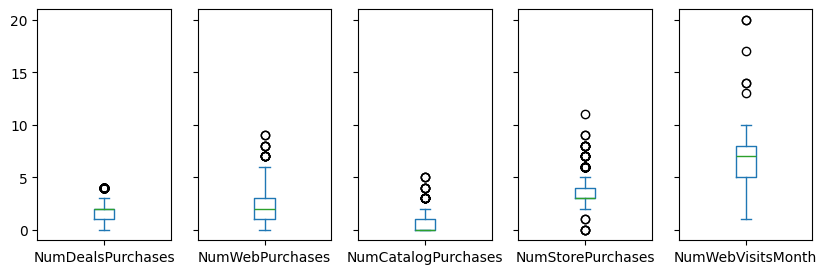

In [63]:
segment_df_kmeans.groupby('Clusters')[num_cols].plot(kind='box', subplots=True, layout=(1,5), figsize=(10,3),sharey=True);

* Cluster 0: HighPurchasePowerCustomers who purchase lot through all channels (web, catalog, and store) with less Web Visit and Deals purchase
* Cluster 1: CommonPurchasePowerCustomers who prefer Web, Store Purchase as well as DealsPurhcase. They visit the web around twice a week
* Cluster 2: PotentialCustomers  who seldom purhcase but like to visit the web around twice a week

#### Analyze segment-specific impact

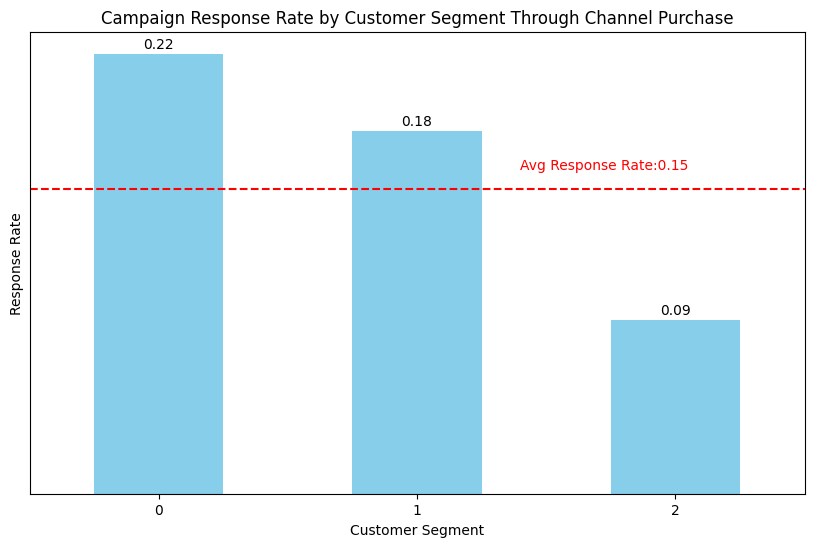

In [64]:
# Calculate response rate for each cluster. 

cluster_response = segment_df_kmeans.groupby('Clusters')['Response'].mean()

#visualize the response rate
ax = cluster_response.plot(kind='bar',figsize=(10,6), color ='skyblue')
plt.bar_label(ax.containers[0],fmt= '%.2f', padding=2)
plt.yticks([])
plt.xticks(rotation=0)
plt.title('Campaign Response Rate by Customer Segment Through Channel Purchase') 
plt.xlabel('Customer Segment')
plt.ylabel('Response Rate')
#Add a horizontal line for the average response rate
plt.axhline(y=food_df_processed['Response'].mean(), color='r', linestyle='--', label='Average Response Rate')
# Add a text in the spare space around the line to indicate the average response rate
plt.text(1.4, food_df_processed['Response'].mean()+0.01, f"Avg Response Rate:{round(food_df_processed['Response'].mean(),2)}", color='red')
# plt.legend()
plt.show()

Cluster 0 has the highest response rate, while Cluster 2 has the lowest response rate. To improve  response rate, the marketing campaign can continue focus on the high purchase power customer. Besides, company needs to create a new marketing policy to those potential customers who visit the website often but purchase less.

### Segment through Purchase Activities

In [108]:
# Extract the purchase activities columns and response column
purchase_cols = [ 'Recency', 'Customer_Days', 'Income','FamilyNumber','Dependents', 'WeightedAffordability', 'CustVal', 'MntGoldProds','MntTotal','MntRegularProds']


In [112]:
segment_df_purchase = food_df_processed[['Response',*purchase_cols]].copy()
# Create customer segments based on the purchase activities
segment_df_purchase_kmeans = create_cluster_segments(segment_df_purchase, purchase_cols)

Best Hyperparameters: {'init': 'random', 'max_iter': 408, 'n_clusters': 3, 'n_init': 97, 'tol': 0.0001}
Best Silhouette Score: 0.30


In [ ]:
# clusters statistics
segment_df_purchase_kmeans.groupby('Clusters')[purchase_cols].describe()

Recency                                                     \
           count       mean        std  min   25%   50%   75%   max   
Clusters                                                              
0         1332.0  48.847598  28.999055  0.0  24.0  49.0  74.0  99.0   
1          289.0  50.446367  28.489119  0.0  27.0  52.0  73.0  99.0   
2          584.0  48.666096  29.024976  0.0  24.0  49.0  73.0  99.0   

         Customer_Days                                                    \
                 count         mean         std     min      25%     50%   
Clusters                                                                   
0               1332.0  2494.767267  200.240831  2159.0  2314.00  2488.5   
1                289.0  2579.238754  186.964184  2160.0  2438.00  2599.0   
2                584.0  2520.743151  208.125826  2160.0  2337.75  2526.0   

                          Income                                       \
             75%     max   count          mean           std      min   
Clusters                                                                
0         2661.0  2858.0  1332.0  39017.892643  14303.272392   1730.0   
1         2740.0  2856.0   289.0  65744.408304  14464.248280   4428.0   
2         2702.0  2857.0   584.0  73381.424658  10742.324565  34445.0   

                                                FamilyNumber            \
               25%      50%       75%       max        count      mean   
Clusters                                                                 
0         28517.50  38530.0  49496.75   79146.0       1332.0  2.927177   
1         57967.00  66426.0  75127.00  105471.0        289.0  2.262976   
2         66432.25  73749.0  80881.50  113734.0        584.0  1.996575   

                                            Dependents                      \
               std  min  25%  50%  75%  max      count      mean       std   
Clusters                                                                     
0         0.829552  1.0  2.0  3.0  3.0  5.0     1332.0  1.260511  0.680634   
1         0.807976  1.0  2.0  2.0  3.0  5.0      289.0  0.643599  0.635442   
2         0.738541  1.0  1.0  2.0  2.0  5.0      584.0  0.388699  0.531617   

                                  WeightedAffordability               \
          min  25%  50%  75%  max                 count         mean   
Clusters                                                               
0         0.0  1.0  1.0  2.0  3.0                1332.0  1836.058559   
1         0.0  0.0  1.0  1.0  3.0                 289.0  3055.927336   
2         0.0  0.0  0.0  1.0  3.0                 584.0  3543.416096   

                                                               CustVal  \
                  std     min     25%     50%      75%     max   count   
Clusters                                                                 
0          653.598620    82.0  1391.0  1818.5  2254.50  4445.0  1332.0   
1         1057.187689   203.0  2434.0  2865.0  3441.00  7233.0   289.0   
2         1162.880171  1483.0  2728.0  3298.0  4055.25  8573.0   584.0   

                                                                      \
              mean       std       min       25%       50%       75%   
Clusters                                                               
0         0.140289  0.161924  0.003076  0.030292  0.057651  0.204540   
1         0.780659  0.367933  0.031327  0.530159  0.742816  1.000365   
2         0.975119  0.329194  0.225931  0.725630  0.929833  1.191079   

                   MntGoldProds                                             \
               max        count        mean        std   min    25%    50%   
Clusters                                                                     
0         1.281690       1332.0   19.765766  20.740624   0.0    5.0   12.0   
1         1.915212        289.0  155.314879  43.067387  86.0  123.0  148.0   
2         2.116776        584.0   44.404110  27.132627   0.0   24.0   3

Similar to the the previous 3 segments, one cluster with the largest number has limited purchase power with lower income and independents in home, they purchase less in all catogories, no matter regular, total or gold.
* one cluster with the least number has avg the highest income and  no dependents in family, they are like to puchase more regular and total products but less interesting in gold 
* The left one is with common income and dependents. They prefer to buy more golds than other clusters

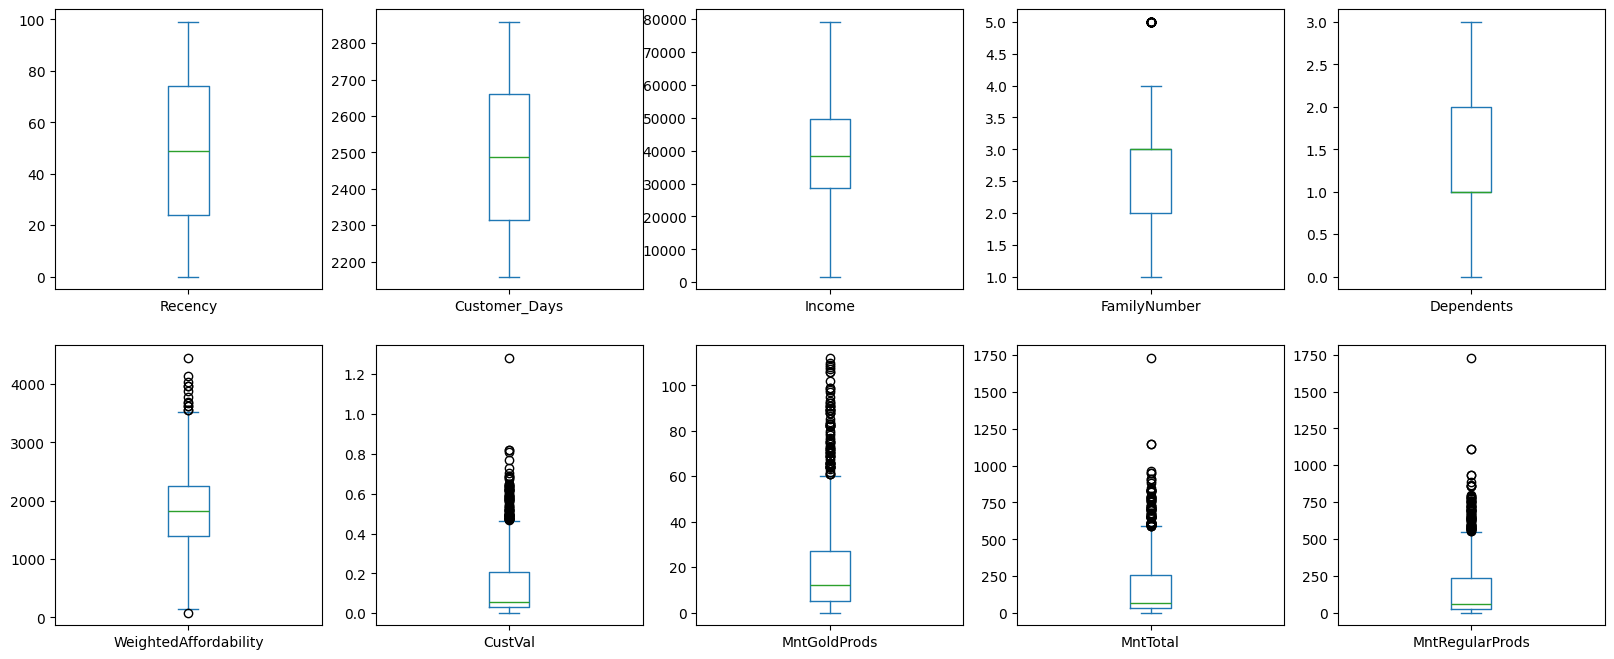

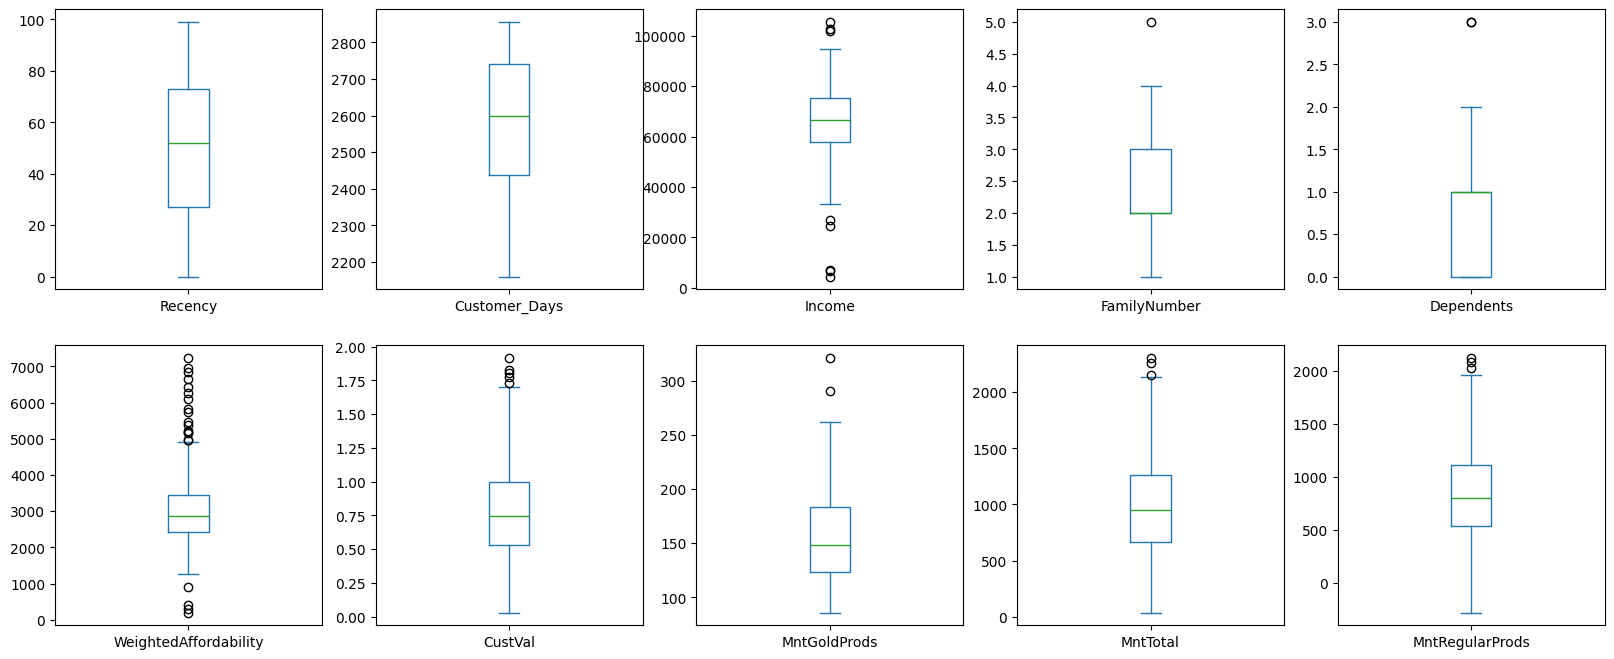

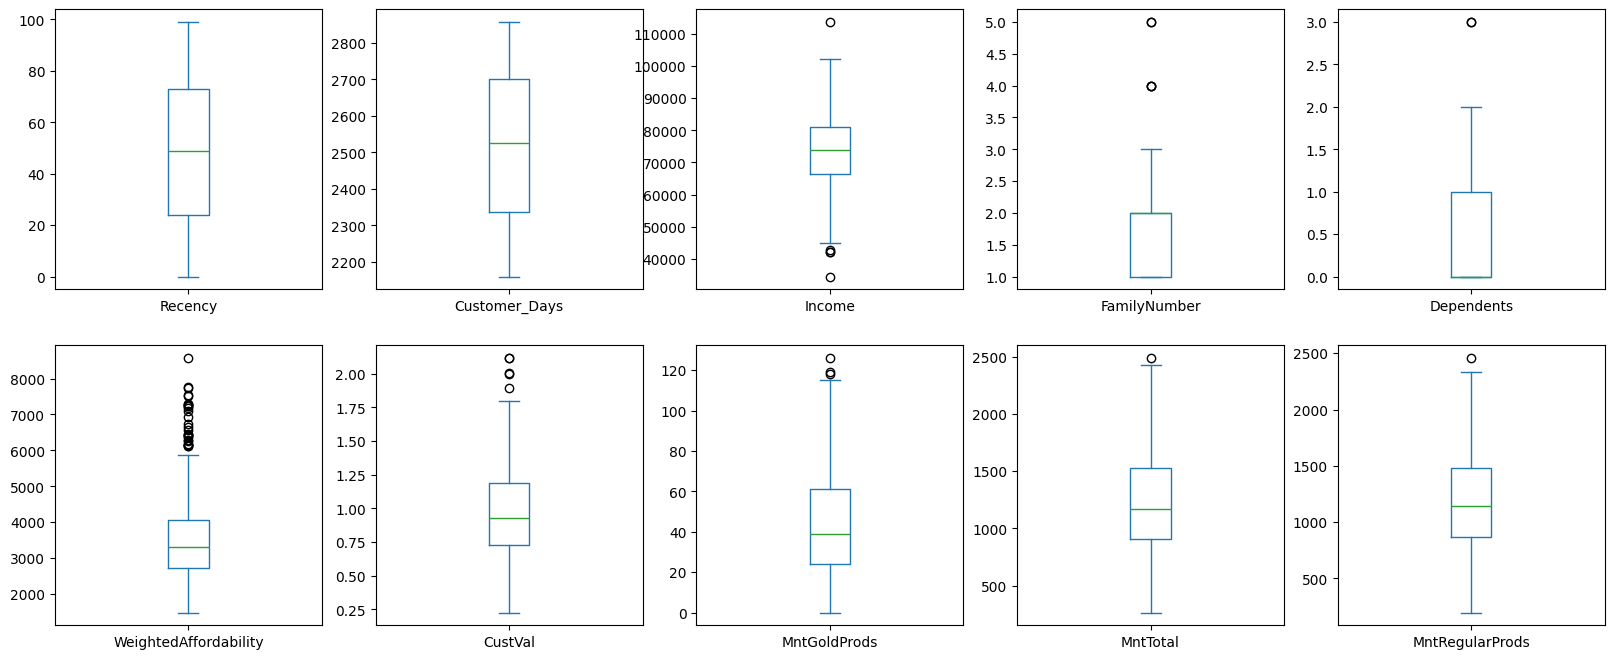

In [117]:
# Clusters box plot
segment_df_purchase_kmeans.groupby('Clusters')[purchase_cols].plot(kind='box', subplots=True, layout=(2,5), figsize=(20,8), );

#### Analyze segment-specific impact

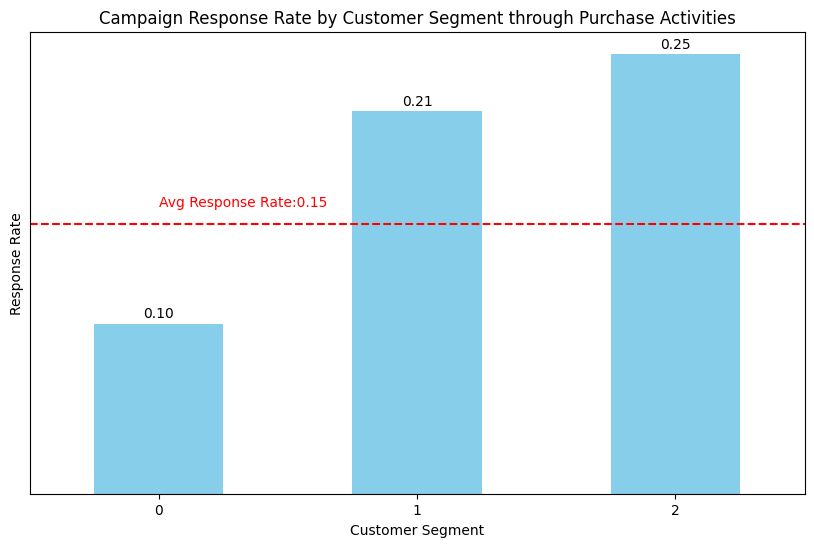

In [119]:
# Calculate response rate for each cluster. 

cluster_response_purchase = segment_df_purchase_kmeans.groupby('Clusters')['Response'].mean()

#visualize the response rate
ax = cluster_response_purchase.plot(kind='bar',figsize=(10,6), color ='skyblue')
plt.bar_label(ax.containers[0],fmt= '%.2f', padding=2)
plt.yticks([])
plt.xticks(rotation=0)
plt.title('Campaign Response Rate by Customer Segment through Purchase Activities') 
plt.xlabel('Customer Segment')
plt.ylabel('Response Rate')
#Add a horizontal line for the average response rate
plt.axhline(y=food_df_processed['Response'].mean(), color='r', linestyle='--', label='Average Response Rate')
# Add a text in the spare space around the line to indicate the average response rate
plt.text(0, food_df_processed['Response'].mean()+0.01, f"Avg Response Rate:{round(food_df_processed['Response'].mean(),2)}", color='red')
# plt.legend()
plt.show()

Cluster 0 has the lowest response rate, while Cluster 2 has the highest response rate. To improve response rate, campaign can continue focus on the high purchase power customer but it needs to define the different strategy for those who prefer gold purchase and those who not. Besides, campaign needs to create a new marketing policy to those customers who has limited income and more family members to raise.

# Summarize and Suggestion
Summarizing the analysis, the key findings and suggestions are as follows:

1. **Customer Segmentation**:
    - **High Purchase Power Customers**: These customers have high income, fewer dependents, and spend significantly on various products. They show the highest response rate to campaigns. Focus on retaining and rewarding these customers with personalized offers and loyalty programs.
    - **Common Purchase Power Customers**: These customers have moderate income and purchase behavior. They respond well to campaigns but not as much as high purchase power customers. Target these customers with attractive deals and promotions to increase their spending.
    - **Potential Customers**: These customers have lower income, more dependents, and visit the website frequently but purchase less. They show the lowest response rate. Develop strategies to convert these visitors into buyers, such as offering discounts, free trials, or targeted marketing campaigns.

2. **Product Preferences**:
    - Customers who spend more on wines, meats, and regular products are more likely to respond to campaigns. Focus on promoting these products in marketing campaigns.
    - Gold product purchasers form a distinct segment. Tailor campaigns specifically for these customers to increase their engagement and spending.

3. **Channel Preferences**:
    - Web and catalog purchases are more indicative of campaign response than store purchases. Enhance online and catalog marketing efforts to boost campaign effectiveness.
    - Deal purchases are less informative for predicting response. Consider revising deal strategies to make them more appealing and effective.

4. **Income and Education**:
    - Higher income is positively correlated with campaign response. Target higher-income customers with premium offers and exclusive deals.
    - Customers with higher education levels, especially those with PhDs, show higher response rates. Tailor marketing messages to resonate with educated customers, highlighting product quality and value.

5. **Marketing Strategy**:
    - Focus on high purchase power customers and develop personalized marketing strategies to retain and reward them.
    - Create targeted campaigns for potential customers to convert them into buyers.
    - Promote products that have higher response rates, such as wines, meats, and regular products.
    - Enhance online and catalog marketing efforts to boost campaign effectiveness.
    - Tailor marketing messages to resonate with higher-income and educated customers.

By implementing these suggestions, the company can improve its marketing campaign effectiveness, increase customer engagement, and boost overall sales.